# <u>0) Ensemble des variables à modifier en début d'exécution du Notebook, selon l'exploitation qu'on veut en faire.</u>

In [1]:
# Booléen d'activation (ou non) de l'installation des modules/librairies/fonctions python.
Installation = False
# Booléen d'activation (ou non) de l'effacement de variables utilisées uniquement sur quelques lignes de codes.
Effacement_varibales_inutiles = False
# Chemin (local) de données vers le répertoire où est rangé la base de données réduite et nettoyée
abs_path_b2d_reduite_csv = 'C:/Users/luked/Documents/Formation_Ingenieur_ML/Projets/P2/Ressources_bases2donnees/'
# Titre de cette base de données.
title_b2d_reduite_csv = 'b2d_reduite_nettoyee.csv'
# Booléens d'activation (ou pas) des lignes de script consacrées à la recherche du nombre optimal de jobs à faire tourner en parallèle (cf section 4.1.6.2) de ce Notebook)
Recherche_n_jobs_optimal = True

# 
# <u>1) Installations et importations des libriaries/modules python utiles pour ce Notebbok.</u>
 
## <u>1.1) Installation (sautez cette étape si vous les avez déjà sur votre ordinateur).</u>

In [2]:
# Installation conditionnée au booléen défini en section 0) de ce Notebook
if Installation :
    ! pip install missingno
    ! pip install sklearn
    ! pip install time

## <u>1.2) Importations des librairies/modules/fonctions utiles pour ce notebook.</u>

In [3]:
# Librairies générales : calcul, graphiques, gestion de tableau, etc
from missingno.missingno import np, pd, sns, plt
from missingno import bar as msnobar
# Fonction spécifique à la PCA
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
# Fonctions spécifiques à la classification par méthode kNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
# Librairie de mesure de temps
import time

## <u>1.3) Définitions de fonctions utiles pour ce notebook.</u>
### Les 3 premières fonctions utilisées ici proviennent du script python functions.py, en ressource du TP consacré à la PCA du cours "Réalisez une analyse exploiratoire de vos données". Le git vers les ressources de ce TP est le suivant : https://github.com/stenier-oc/realisez-une-analyse-de-donnees-exploratoire. 
### !!! JE NE M'ATTRIBUE EXPLICITEMENT PAS LA CONCEPTION DE CES FONCTIONS !!!

In [4]:
# Importation d'une fonction supplémentaire
from matplotlib.collections import LineCollection
# (PCA) Fonction produisant un cercle de corrélations sur un certains nombre de plans factoriels
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:
            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(10,10))
            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])
            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)
            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')
            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
# (PCA) Fonction produisant une projection des individus du jeu de données sur un certains nombre de plans factoriels
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
            # initialisation de la figure       
            fig = plt.figure(figsize=(10,10))       
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()
            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center')                 
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')
            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))
            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
# (PCA) Fonction produisant l'éboulis des valeurs propres
def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False) 

# 
# <u>2) Chargement de la base de données réduite et nettoyee (notée par la suite "b2d").</u>

In [5]:
#Chargement de la b2d reduite, enregistree sous format .csv
df_b2dred1 = pd.read_csv(abs_path_b2d_reduite_csv + title_b2d_reduite_csv, sep='\t')

### On affiche quelques lignes de la b2d pour s'assurer que le chargement s'est bien passé.

In [6]:
df_b2dred1.head()

Unnamed: 0 pnns_groups_1 pnns_groups_2  energy-kcal_100g  fat_100g  \
0           2       unknown       unknown             375.0       7.0   
1           4       unknown       unknown             163.9       1.9   
2           5       unknown       unknown             874.9      15.1   
3           9       unknown       unknown              21.0       0.0   
4          10       unknown       unknown              60.0       3.0   

   saturated-fat_100g  trans-fat_100g  cholesterol_100g  carbohydrates_100g  \
0                3.08             NaN               NaN                70.1   
1                1.00             NaN               NaN                 NaN   
2                6.10             NaN               NaN                 2.6   
3                0.00             NaN               NaN                 4.8   
4                1.00             NaN               NaN                10.0   

   sugars_100g  fiber_100g  proteins_100g  sodium_100g  vitamin-a_100g  \
0         15.0         NaN            7.8        0.560             NaN   
1          NaN         NaN           15.3        0.440             NaN   
2          1.0         NaN           15.7        0.840             NaN   
3          0.4         NaN            0.2        0.816             NaN   
4          3.0         NaN            2.0        0.460             NaN   

   vitamin-c_100g  calcium_100g  iron_100g  \
0             NaN           NaN        NaN   
1             NaN           NaN        NaN   
2             NaN           NaN        NaN   
3             NaN           NaN        NaN   
4             NaN           NaN        NaN   

   fruits-vegetables-nuts-estimate-from-ingredients_100g  \
0                                                NaN       
1                                                NaN       
2                                                NaN       
3                                                NaN       
4                                                NaN       

   nutrition-score-fr_100g  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN

### On note que les indices restant de l'ancienne base (après réduction et nettoyage) ont été transformés en une nouvelle colonne, 'Unnamed:0' tout à la gauche du Dataframe.
### On supprime cette colonne, inutile pour la suite de notebook :

In [7]:
df_b2dred1 = df_b2dred1.drop(columns='Unnamed: 0')

### On affiche également -de nouveau- le graphe de densité de remplissage, afin de confirmer le bon chargement de la b2d réduite et nettoyée.

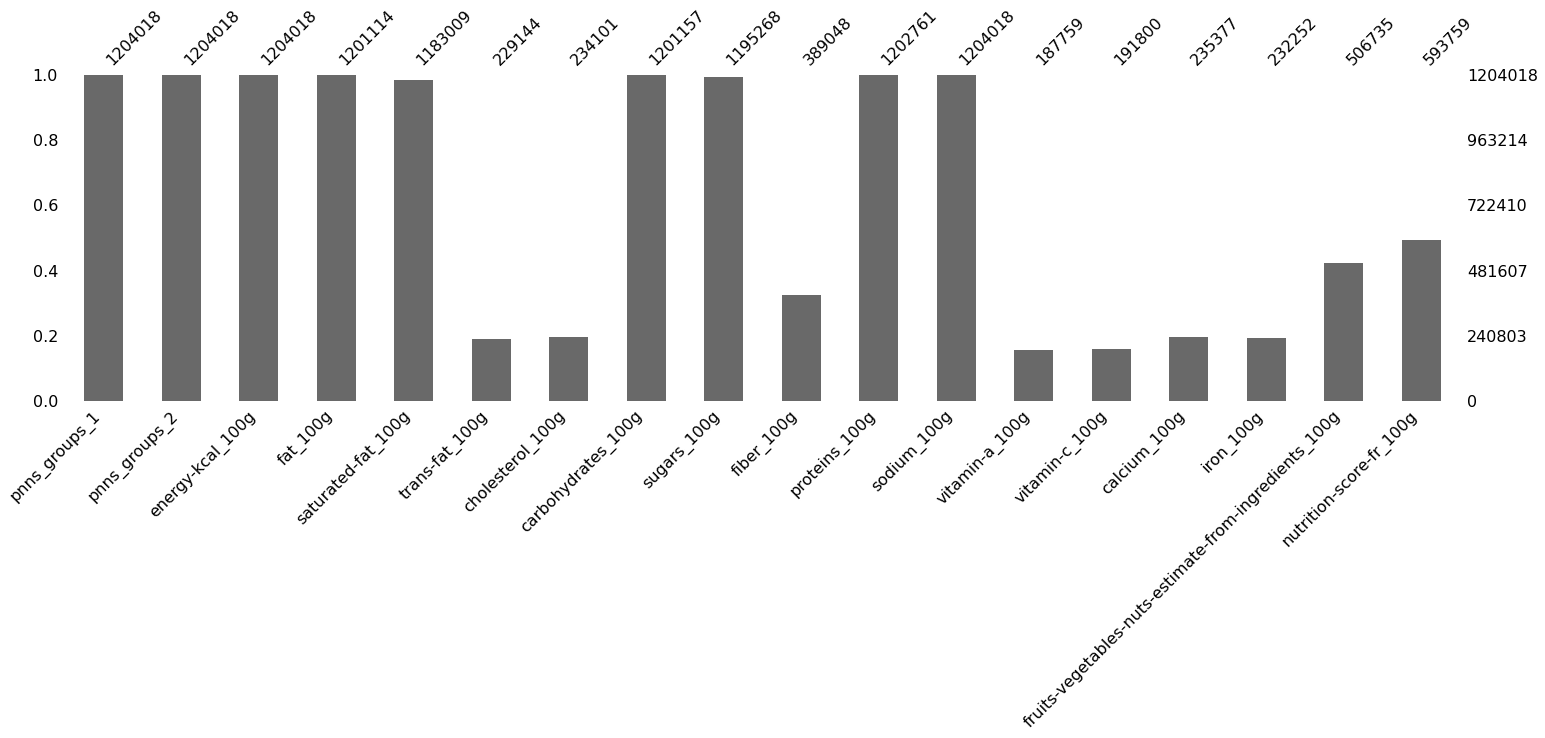

In [8]:
msnobar(df_b2dred1, figsize=(25,6))

### Nous voici rassurés.
# 
# <u>3) Analyses.</u>
### On commence par créer quelques variables pour faciliter notre travail à venir :

In [9]:
# Colonnes
cln = df_b2dred1.columns
# Dataframes des groupes pnns et des nutrition fact
df_pnns, df_100g = df_b2dred1[cln[cln.str.contains('pnns')]], df_b2dred1[cln[cln.str.contains('100g')]]
# Dataframe ne contenant que les groupes pnns de type 1 et le nutrition facts (explication de cette restriction en section 3.1.2.2)
df = df_b2dred1[cln[cln.str.contains('pnns_groups_1|100g')]]

## <u>3.1) Analyses univariées.</u>
### 
### <u>3.1.2) Répartition des différentes catégories et sous-catégories au sein des pnns_groups_1 et 2:</u>
### Pour notre application, l'une des choses les plus importantes à faire est d'être capable d'identifier, parmi les catégories d'aliments (donc parmi les deux groupes pnns), celles qui sont globalement les plus saines. 
### Commençons donc par regarder la distribution des différentes catégories au sein des paramètres pnns_groups_1 et 2, afin de savoir si des catégories sont plus représentées que d'autres.
#### <u>3.1.2.1) Distribution des différentes catégories au sein du paramètres pnns_groups_1 :</u>
### On commence par produire un dictionnaire qui nous servira pour l'affichage graphique : il associe à chaque sous-catégorie de pnns_groups_2 la catégorie de pnns_groups_1 qui la contient.

In [10]:
# variable contenant les clef du futur dictionnaire : chaque sous-catégorie de pnns_groups_2
pnns_2 = df_pnns['pnns_groups_2'].value_counts().keys()
# liste contenant les catégories de pnns_groups_1 correspondant à chaque sous-catégorie de pnns_groups_2
tab = [df_pnns['pnns_groups_1'].where(df_pnns['pnns_groups_2']==clef_2).dropna(axis=0).unique()[0] for clef_2 in pnns_2]#
# création du dictionnaire
d = dict(zip(pnns_2, tab))
if Effacement_varibales_inutiles :
    del pnns_2

In [11]:
### Ici, on fait un dictionnaire similaire, mais construit d'une façon différente
pnns_1, pnns_2 = df_pnns['pnns_groups_1'], df_pnns['pnns_groups_2']
tabbb = np.concatenate([[[clef1, clef2] for clef2 in pnns_2.where(pnns_1==clef1).dropna(axis=0).unique()] for clef1 in pnns_1.value_counts().keys()])
dd = dict(zip(tabbb[:,1], tabbb[:,0]))
if Effacement_varibales_inutiles :
    del pnns_1, pnns_2

### On affiche le pourcentage de représentativité de chacune des catégories du groupe pnns 1 :

In [12]:
100*df_pnns['pnns_groups_1'].value_counts()/df_pnns.shape[0]

unknown                    56.341184
Sugary snacks               9.106259
Fish Meat Eggs              7.055708
Milk and dairy products     6.477312
Cereals and potatoes        5.038712
Composite foods             3.968462
Fat and sauces              3.887982
Beverages                   2.898046
Fruits and vegetables       2.867233
Salty snacks                2.271893
Alcoholic beverages         0.087208
Name: pnns_groups_1, dtype: float64

### Puis on affiche la distribution correspondante :

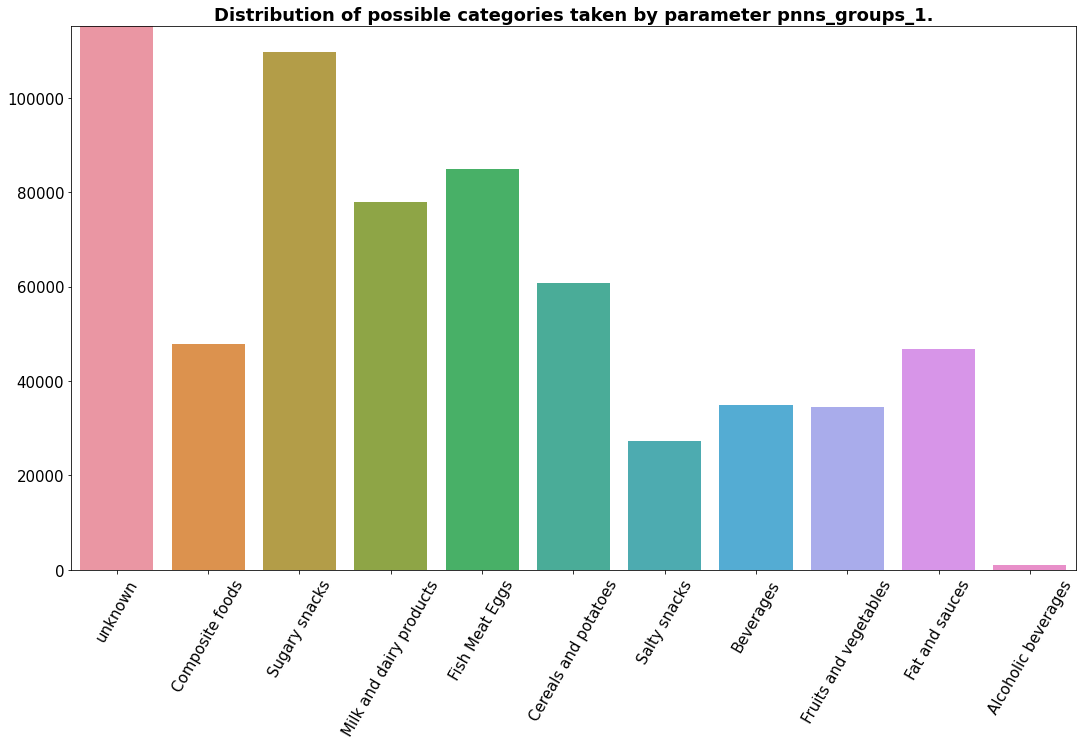

In [13]:
plt.figure('Barplot distrib pnns_1', figsize=(18,10)), plt.clf()
plt.title('Distribution of possible categories taken by parameter pnns_groups_1.', fontweight='bold', size=18)
# création des variables x et y qui seront dans le graphe ci-dessous
x, y = df_pnns['pnns_groups_1'].value_counts().keys(), df_pnns['pnns_groups_1'].value_counts()
barplot = sns.barplot(x=x, y=y, order=df_pnns['pnns_groups_1'].unique())
barplot.set_xticklabels(labels=barplot.get_xticklabels(), size=15, rotation=60)
ymax = y[1:].max()*1.05
plt.yticks(size=15), plt.ylim([0, ymax]), plt.ylabel('')
if Effacement_varibales_inutiles :
    del x, y, ymax, barplot

### Ormis le majoritaire groupe 'unkown', et la catégorie ultra-minoritaire, les autres catégories sont à peu près équitablement représentées dans la b2d.
### 
#### <u>3.1.2.2) Distribution des différentes catégories au sein du paramètres pnns_groups_2 :</u>
### On procède de façon analogie pour les sous-catégories qui composent pnns_groups_2

In [14]:
100*df_pnns['pnns_groups_2'].value_counts()/df_pnns.shape[0]

unknown                             56.341184
Biscuits and cakes                   4.643203
Dressings and sauces                 3.440397
Cheese                               3.313240
Sweets                               3.149953
One-dish meals                       3.040237
Processed meat                       2.878778
Milk and yogurt                      2.248471
Fish and seafood                     2.027046
Cereals                              2.012844
Meat                                 1.883277
Vegetables                           1.835936
Bread                                1.622982
Sweetened beverages                  1.132126
Salty and fatty products             1.013606
Chocolate products                   0.899073
Appetizers                           0.826400
Pizza pies and quiches               0.637117
Breakfast cereals                    0.629143
Legumes                              0.588114
Fruits                               0.521836
Unsweetened beverages             

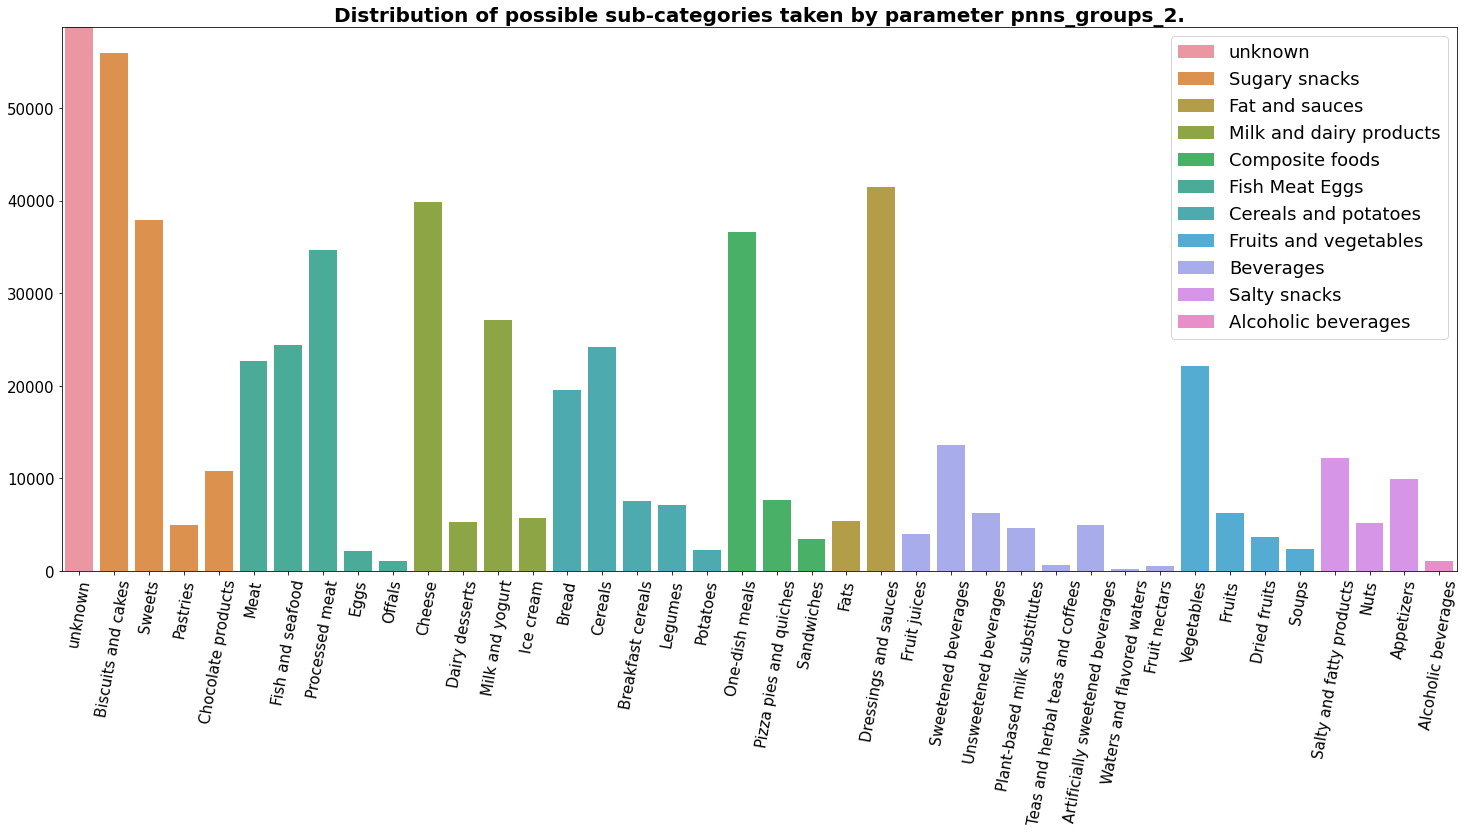

In [15]:
plt.figure('Barplot distrib pnns_2', figsize=(25,10)), plt.clf()
plt.title('Distribution of possible sub-categories taken by parameter pnns_groups_2.', fontweight='bold', size=20)
x, y = df_pnns['pnns_groups_2'].value_counts().keys(), df_pnns['pnns_groups_2'].value_counts()
# !!! utilisation des dictionnaires précédents pour gérer l'affichage des couleurs, et de l'ordre des bar, en fonction des associations catégories <-> sous catégories
barplot = sns.barplot(x=x, y=y, dodge=False, order=pd.Series(tabbb[:,1]), hue=pd.Series(d))
plt.xticks(rotation=80, size=15), plt.xlabel('')
ymax = y[1:].max()*1.05
plt.yticks(size=15), plt.ylim([0, ymax]), plt.ylabel('')
plt.legend(fontsize=18, loc='upper right')
if Effacement_varibales_inutiles :
    del x, y, ymax, barplot

### On constate donc que les sous catégories ne respectent pas exacetment la hiérarchie établies entre les catégories correspondantes pour pnns_groups_1, ce qui traduit une hétérogénité de distribution exacerbée.
### !!!
### !!! Il y a risque que cette hétérogénéité déséquilibre nos prédictions futures ; on fera donc le choix de se restreindre dans ce Notebook aux catégories de pnns_groups_1 dans un premier temps. !!!
### !!!
### 
### <u>3.1.3) Distribution des différentes catégories au sein des <i>nutition facts</i> :</u>
### Concentrons nous désormais sur la distributions des paramètres correspondant aux nutrition facts (ceux exprimés en quantité pouyr 100g de produit).
### On affiche les distributions dans les histogrames suivants, en procédant à un traitement particulier pour la distribution de nutriscore, et celle de l'énergie :

C:\Users\luked\anaconda3\envs\virtucon\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


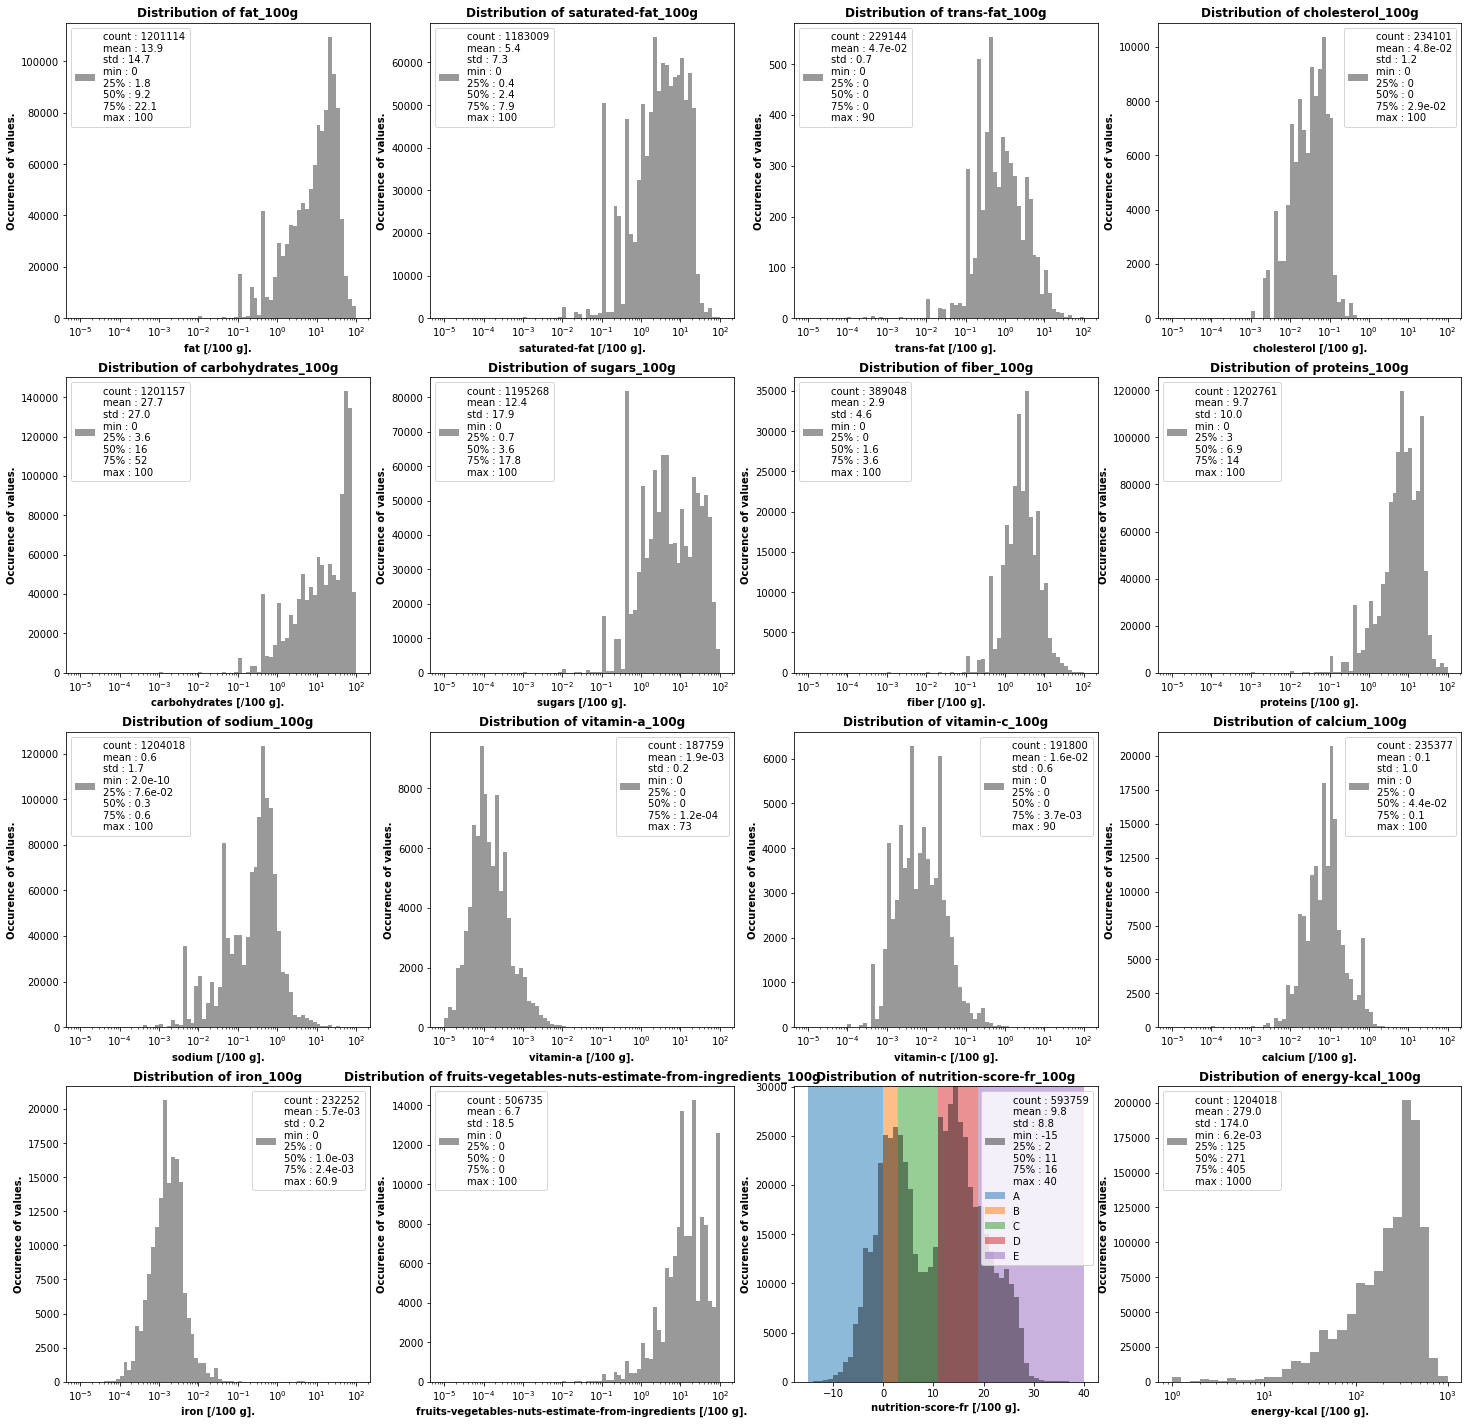

In [16]:
# On calcule les nombre de colonnes de subplots en fonction du nombre de paramètres retenus au sein des nutrition facts
nb_col_subplots = np.sqrt(df_100g.shape[1]) if int(np.sqrt(df_100g.shape[1]))==np.sqrt(df_100g.shape[1]) else int(np.sqrt(df_100g.shape[1]))+1
# Même nombre de lignes que de colonnes pour la disposition des subplots, de sorte à toujours avoir une disposition de subplots en carré
nb_lig_subplots = nb_col_subplots
plt.figure('Distributions Nutritions facts', figsize=(25,25))
# On parcours les nutrition facts en commençant par tous ceux qui représentent une masse de nutriment pour 100g (energy-kcal_100g, premier de la liste, passe en dernier)
for i, s in enumerate(np.concatenate((df_100g.columns[1:], [df_100g.columns[0]]))):
    plt.subplot(nb_lig_subplots, nb_col_subplots, i+1), plt.title(f'Distribution of {s}', fontweight='bold')
    # Traitement particulier pour ceux qui représente une masse de nutriment pour 100g (donc qui ne sont ni energy_100g ni nutrition-score_100g)
    if np.logical_not(np.logical_or(s.startswith('energy'), s.startswith('nutrition'))):
        kde, bins = False, np.logspace(-5,2,71)
        plt.xscale('log')
    # Traitement particulier pour ceux qui représente un nutrisocre    
    elif s.startswith('nutrition') :
        kde, bins = False, np.arange(-15,41,1)
        if kde==False :
            plt.ylim([0, df_100g[s].value_counts().max()])
            for tab_x, grade in zip([[-15,0],[0,3],[3,11],[11,19],[19,40]], ['A','B','C','D','E']):
                plt.fill_between(tab_x, 0, df_100g[s].value_counts().max(), alpha=0.5, label=grade)
    # Traitement particulier pour ceux qui représente une énergie
    elif s.startswith('energy') :
        kde, bins = False, np.logspace(0,3,31)
        plt.xscale('log')
    text, description = '', dict(df_100g[s].describe())
    # on met en légende de chaque graphes une description statistique du paramètre concerné
    for clef in description:
        text += '%s : %i\n'%(clef, description[clef]) if description[clef]==int(description[clef]) else '%s : %.1e\n'%(clef, description[clef]) if description[clef]<0.1 else '%s : %.1f\n'%(clef, description[clef])
    sns.distplot(df_100g[s], kde=kde, bins=bins, label=text[:-1], color='black')
    plt.legend(loc='best'), plt.xlabel(f'{s[:-5]} [/100 g].', fontweight='bold'), plt.ylabel('Occurence of values.', fontweight='bold')
if Effacement_varibales_inutiles :
    del i,clef,description,text,kde,bins


### Ces graphes révèlent de grandes disparités de distributions, y compris entre nutrition fact exprimés en masse pour 100g, ce qui est une conséquence de la nature des grandeurs représentées. 
### Attention cependant : comme le révèlent les informations en légende, de nombreux paramètres possèdent un grand nombre de 0 (ce que l'échelle logarithmique tend à dissimuler), en particuliers ceux qui possèdent le moins de valeurs définies (comme transfat_100g, cholesterol_100g ou fruits-vegetables-nuts_100g).
### Pour ces paramètres en particulier, ce grand nombre de zéros risque de rendre compliqué la discrimination de certaines catégories.
### De plus, il est donc impossible d'assimiler leur distributions à celles de gaussiennes mono-mode, ce qui pouvait être le cas pour les distributions de paramètres avec beaucoup moins de zéros (tels que fat_100g, energy_100g, ou proteins_100g) qui sont d'ailleurs souvent ceux avec un taux de remplissage proche de 100%.
### On a donc un jeu de données assez hétérogène, et dont plusieurs composantes peuvent poser problème pour notre prédiction.

## <u>3.2) Analyses multivariées.</u>
### <u>3.2.1) Affichage des distribution des catégories de pnns_groups_1 par type de nutrition facts.</u>

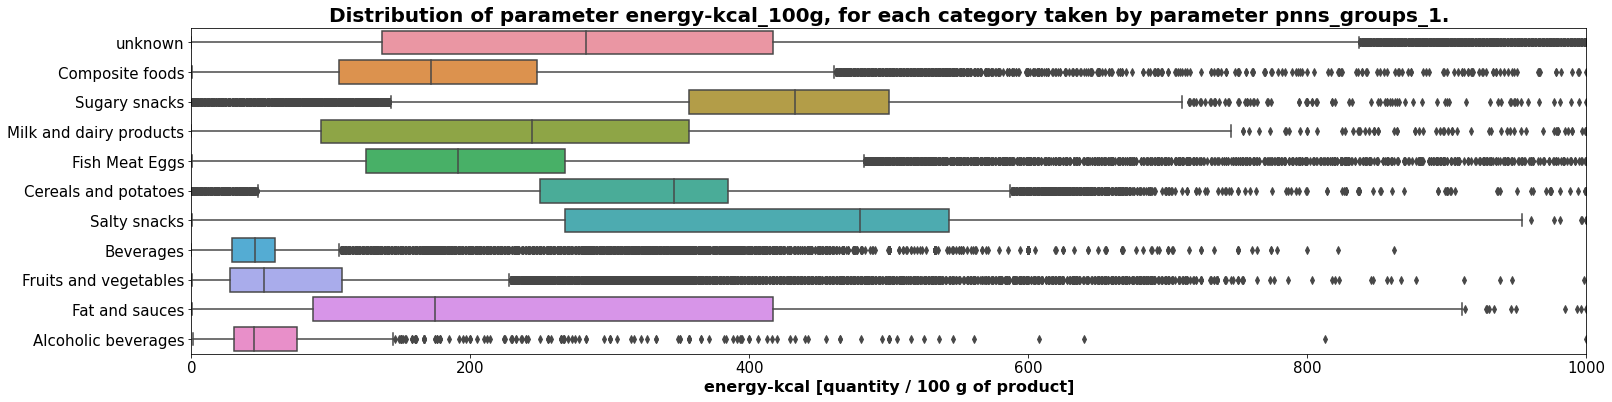

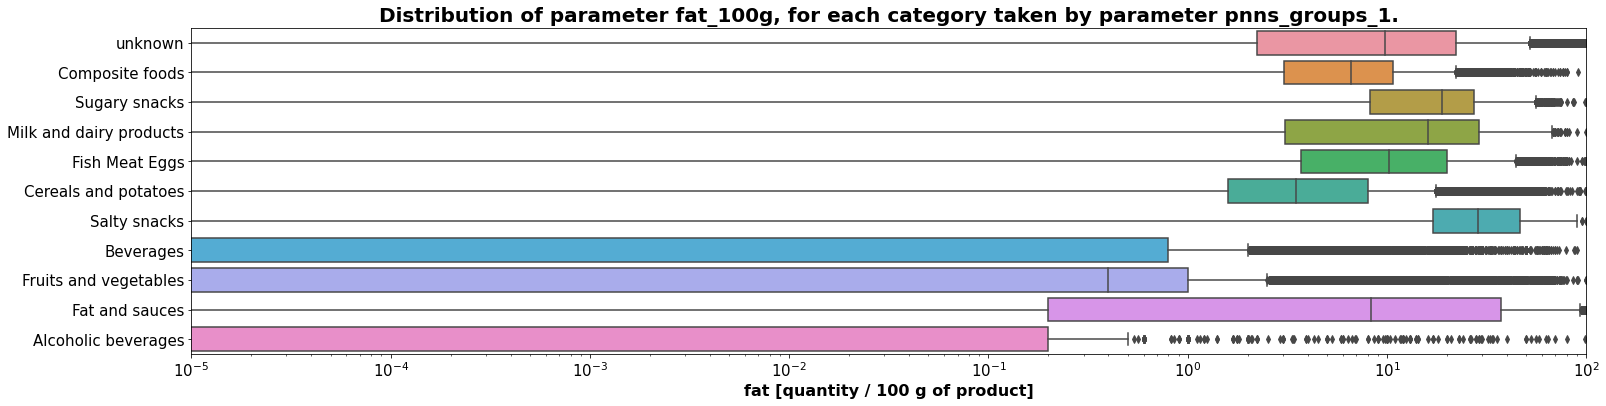

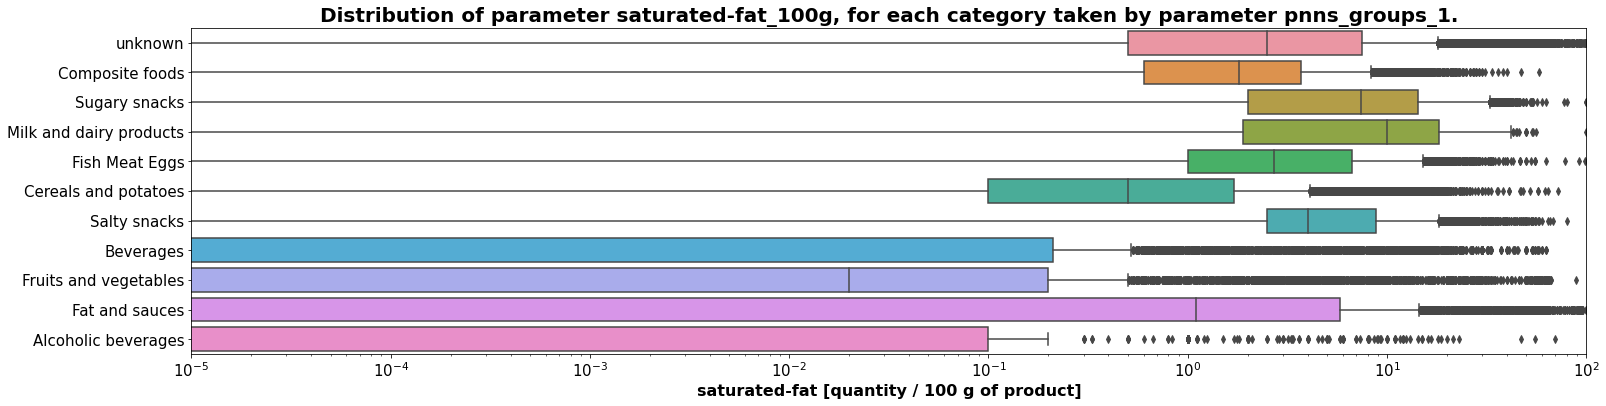

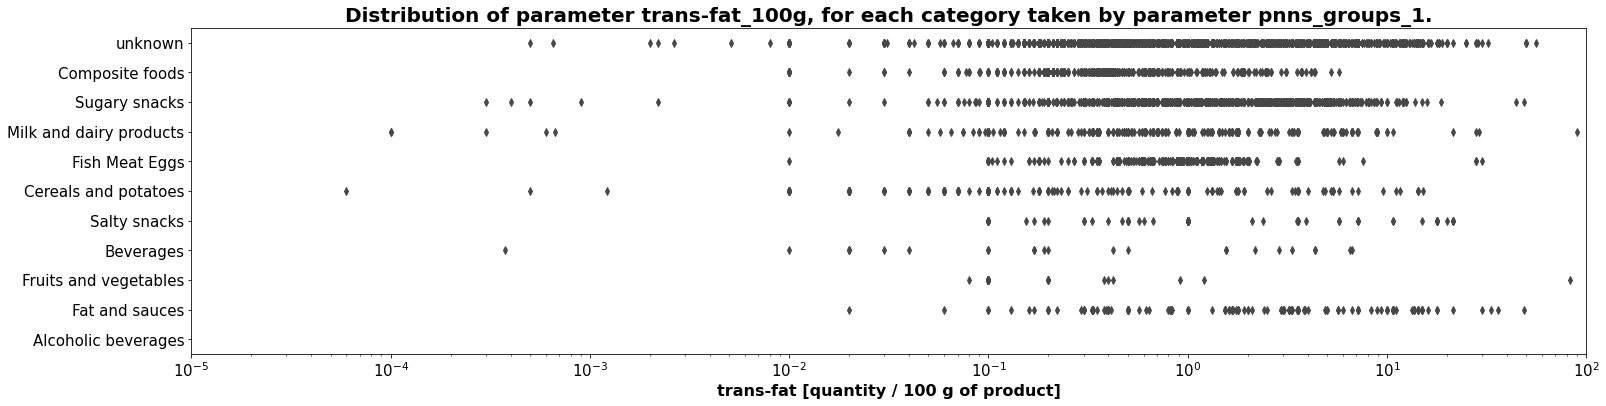

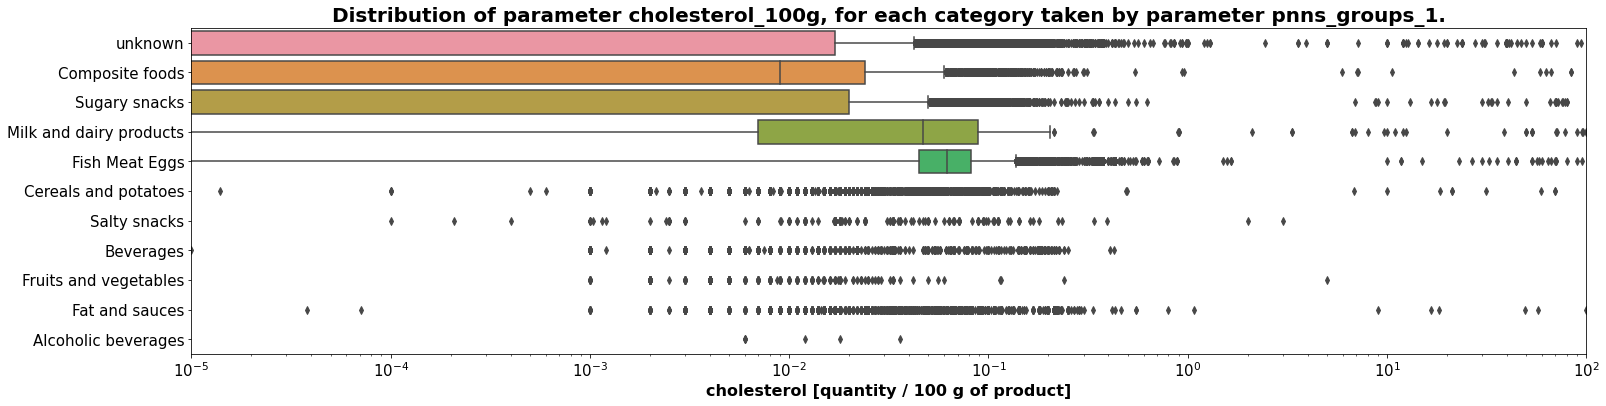

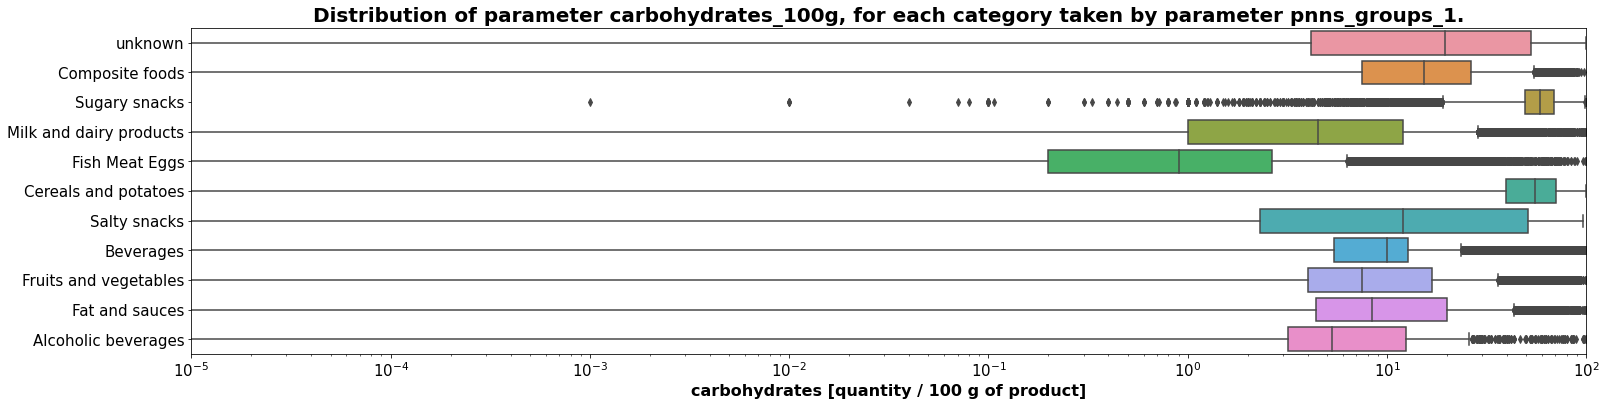

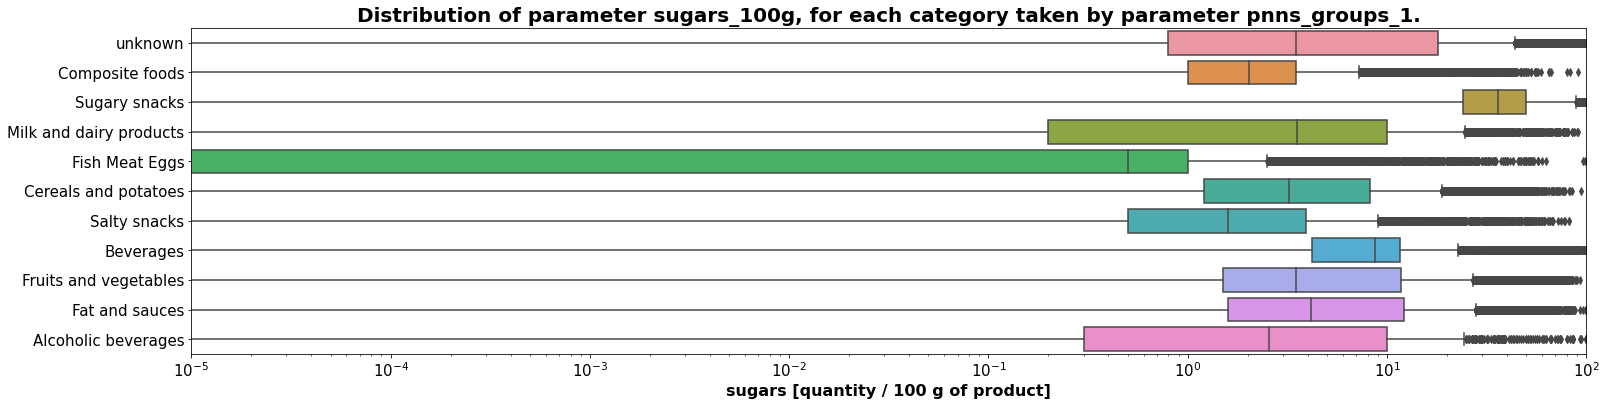

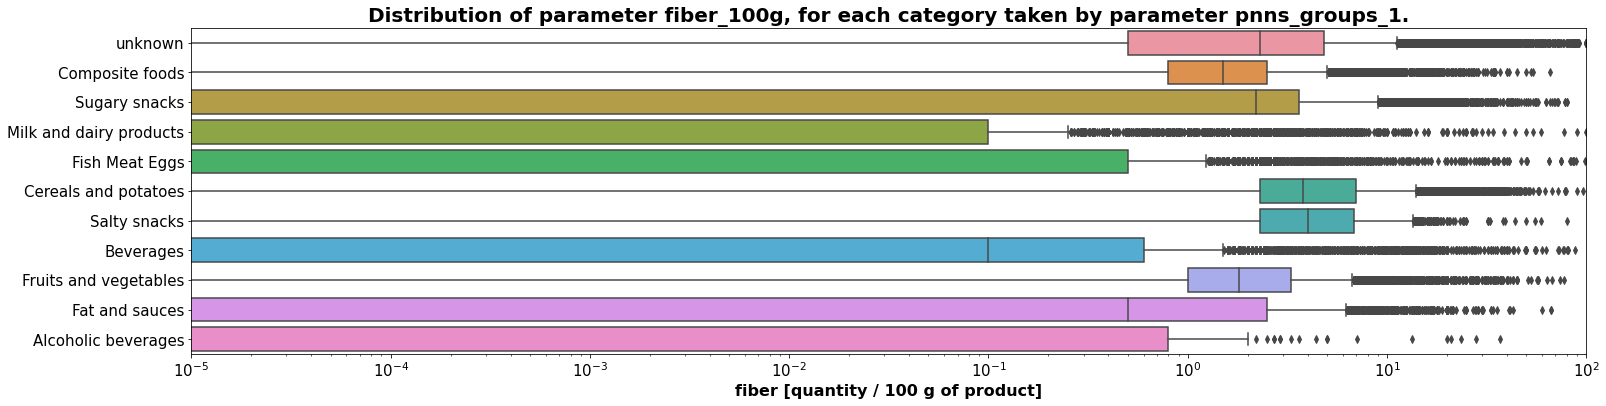

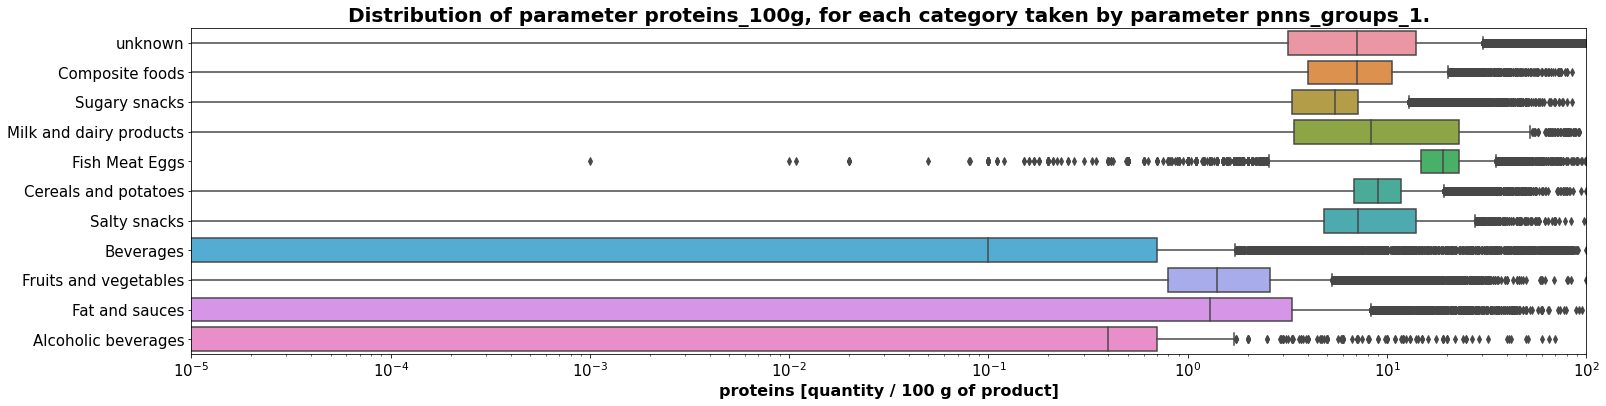

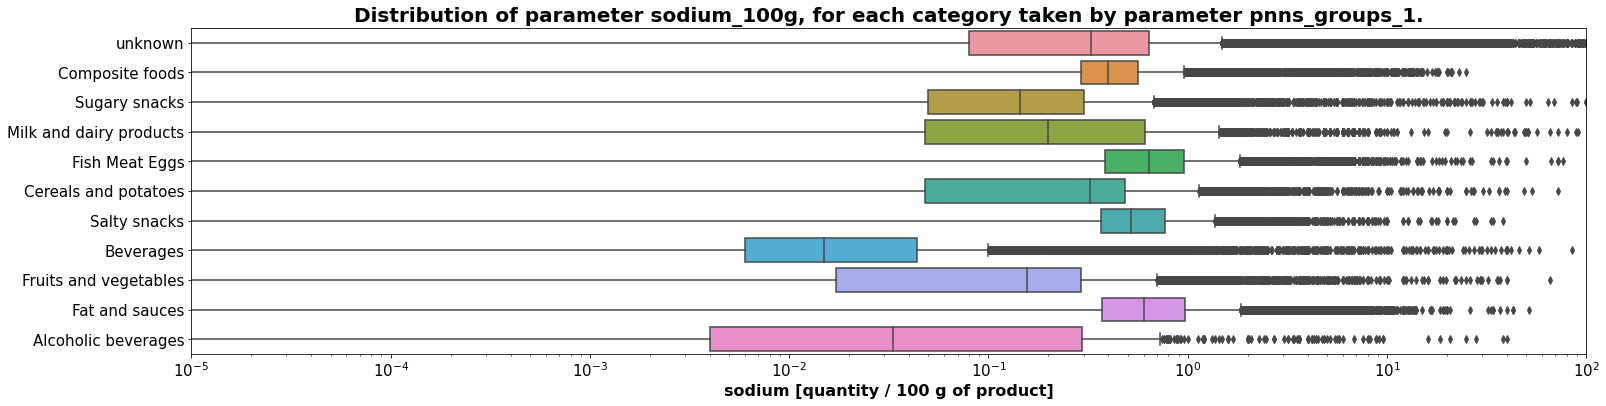

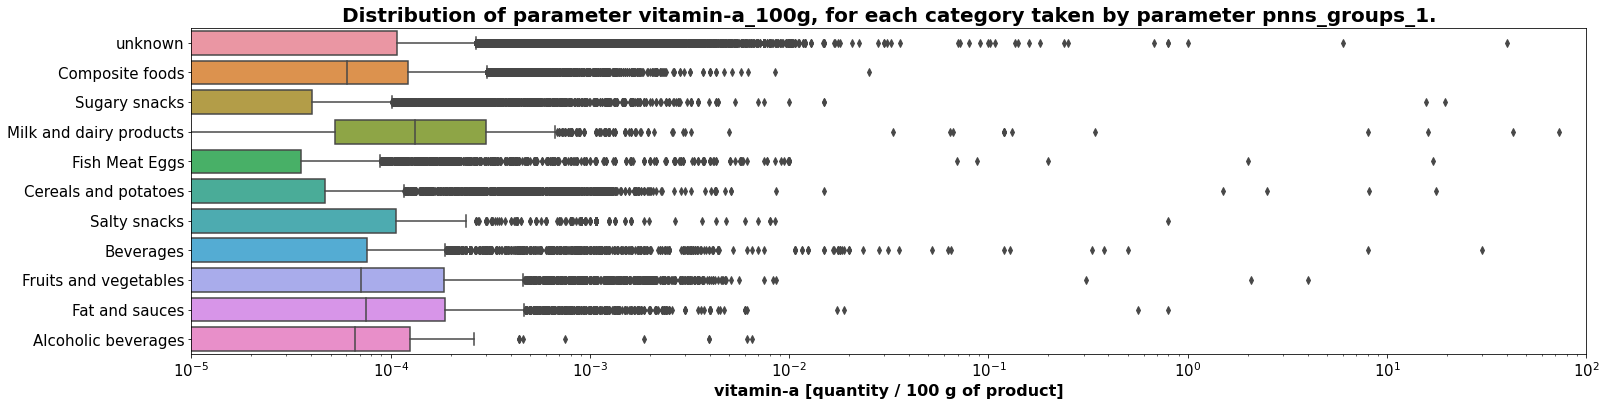

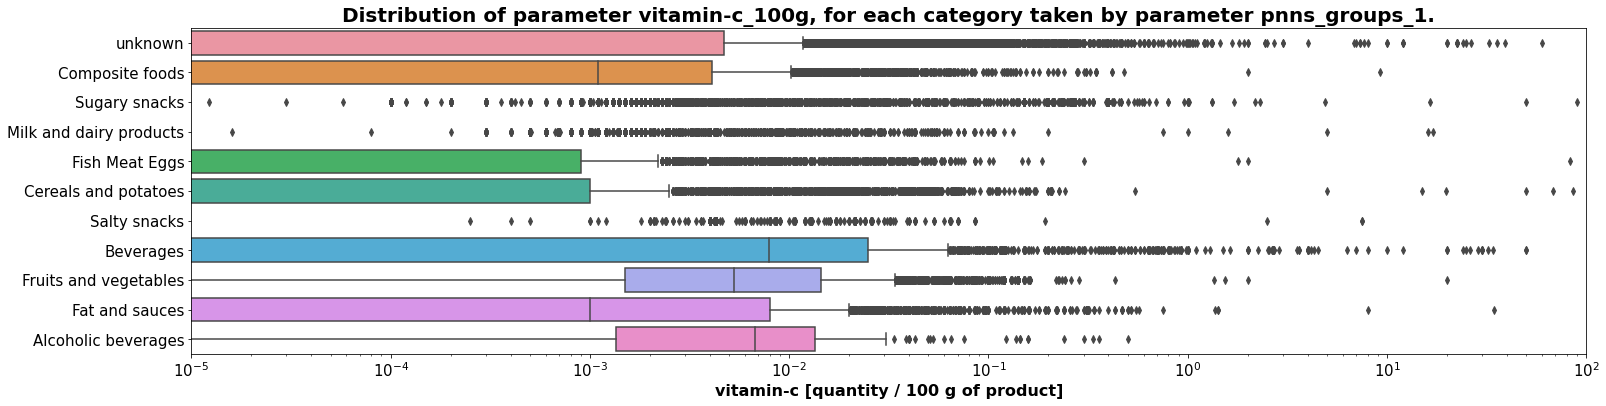

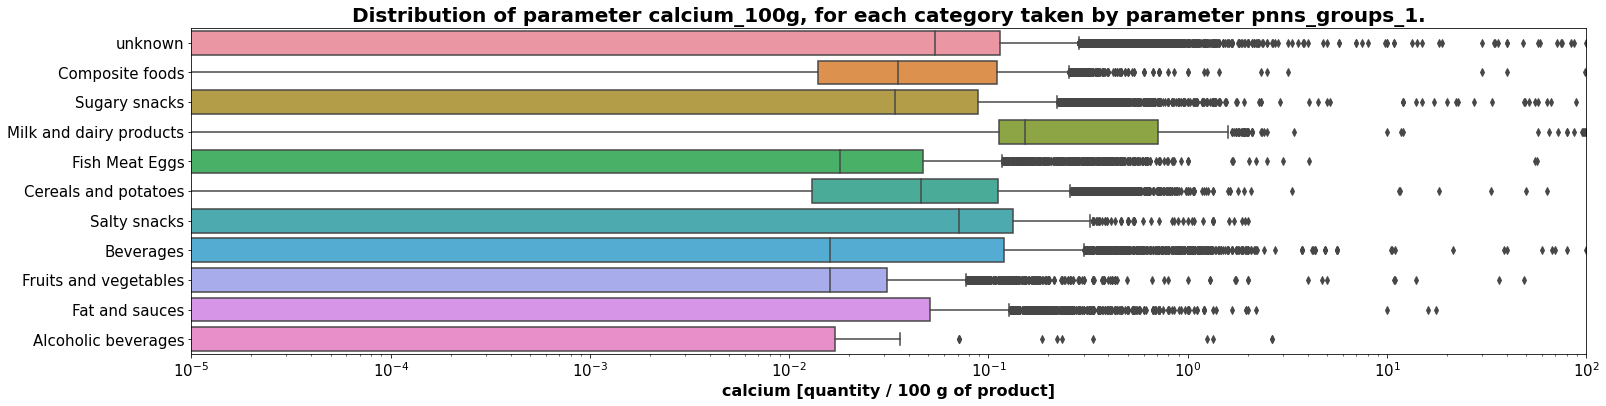

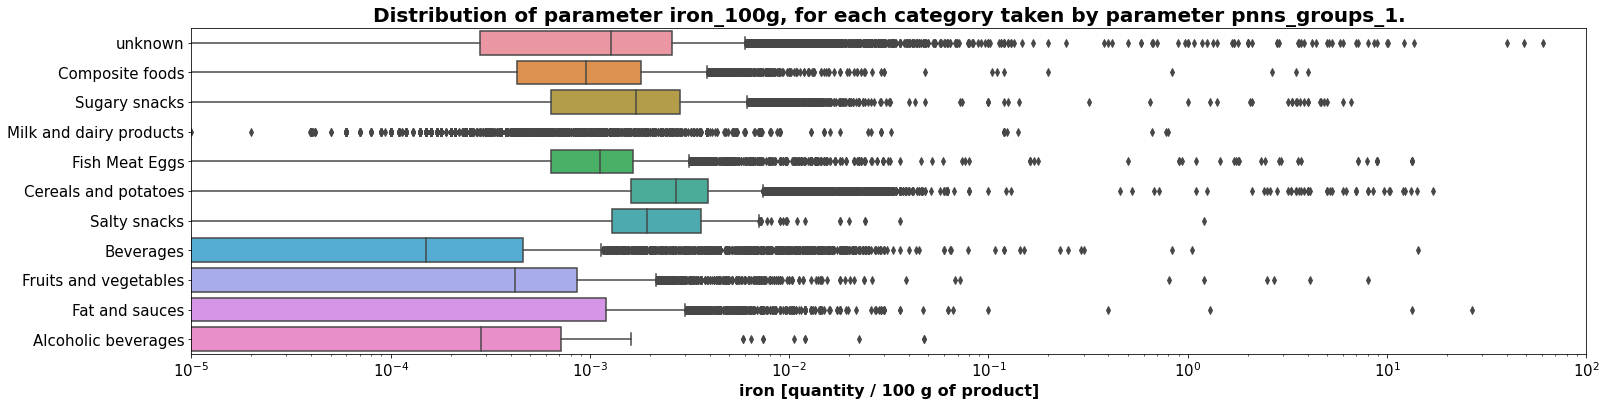

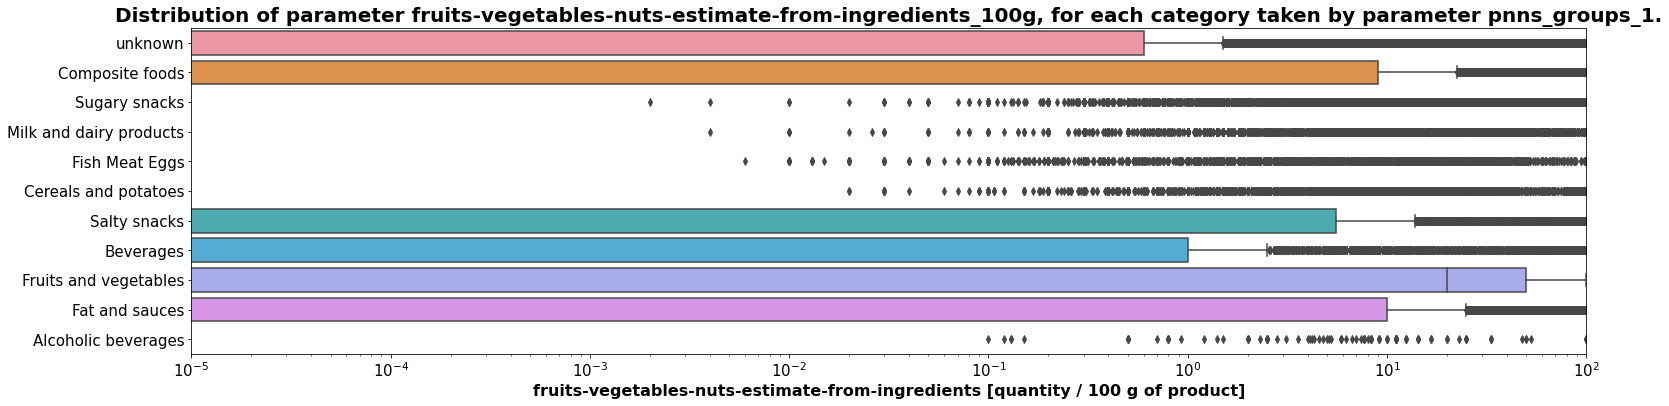

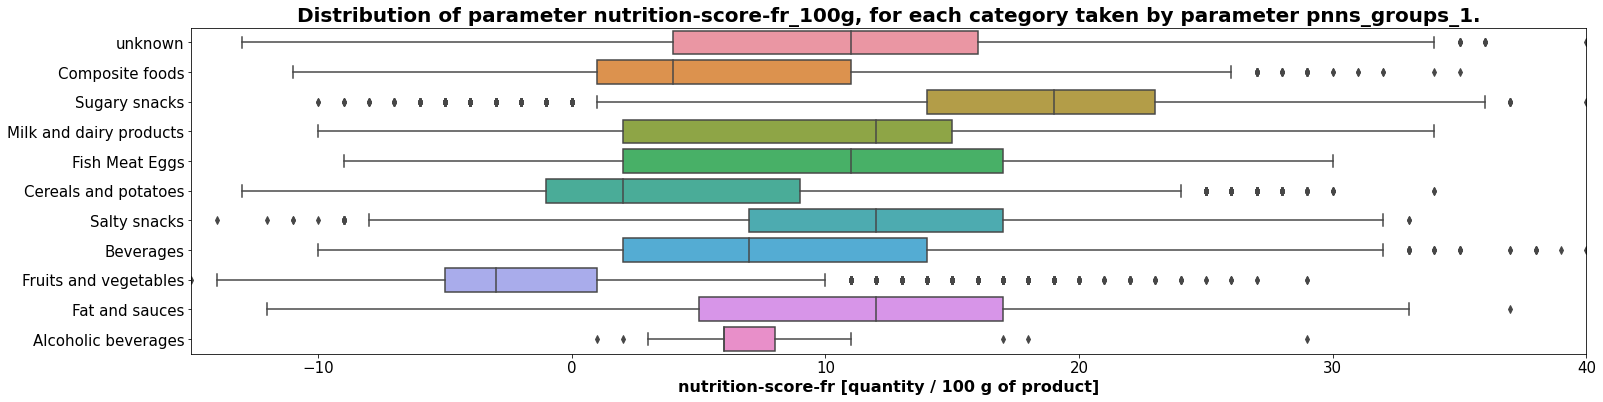

In [17]:
for s in df_100g.columns:
    plt.figure(f'Distribution du param {s} pour chaque groupe pnns 1',figsize=(25,6)), plt.clf()
    plt.title(f'Distribution of parameter {s}, for each category taken by parameter pnns_groups_1.', fontweight='bold', size=20)
    if s=='energy-kcal_100g':
        plt.xlim([0,1e3])
        #boxplot=sns.boxplot(y='pnns_groups_1', x=s, data=df)
    elif s=='nutrition-score-fr_100g':
        plt.xlim([-15,40])
        #boxplot=sns.boxplot(y='pnns_groups_1', x=s, data=df)
    else :
        plt.xscale('log'), plt.xlim([1e-5,1e2])
    boxplot=sns.boxplot(y='pnns_groups_1', x=s, data=df)#.where(df[s]!=0))
    xlabel = s.replace('_100g', ' [quantity / 100 g of product]')
    plt.xlabel(f'{xlabel}', fontweight='bold', size=16)
    plt.ylabel(''), plt.xticks()
    plt.yticks(size=15), plt.xticks(size=15)
if Effacement_varibales_inutiles :
    del s, xlabel

### D'un paramètre de type 'nutrition fact' à un autre, la distribution des éléments "unknown" semble ne jamais suivre l'aspect de celle d'une même autre catégorie. Par exemple : 
- sa distribution ressemble à celle de "milk and dairy products" pour ce qui est du paramètre "fat_100g" ;
- alors que pour "carbohydrates_100g", sa distribution s'aligne sur celle de la catégorie "Cereals and potatoes" ;
- etc

### 
### <u>3.2.2) Analyse anova.</u>

### Suite aux graphiques précédents, on se demande à quel point la somme des variations de catégorie de pnns_groups_1 peut contribuer à la somme des variations totales au sein d'un paramètre de type nutrition fact.
### Pour ce faire, on calcule le rapport de corrélation 'eta**2' pour chacun des nutrition facts.
### On se base sur la méthode de calcul "à la main" donnée dans le cours 'Décrivez et nettoyez votre jeu de données' donné en ressource de ce projet (https://openclassrooms.com/fr/courses/4525266-decrivez-et-nettoyez-votre-jeu-de-donnees/4774896-analysez-une-variable-quantitative-et-une-qualitative-par-anova), qu'on applique ainsi :
- la variable quantitative est un nutrition fact ;
- la variable qualitative est le paramètre pnns_groups_1 (les 'classes' sont donc les catégories qui peuplent ce paramètre).

### On calcule ce rapport pour chaque nutrition fact.

In [18]:
# la variable qualitative : les catégories de pnns_groups_1
X = df_pnns['pnns_groups_1']
tab_eta_carre = []
# on parcours les paramètres de type nutrition facts
for s in df_100g.columns :
    # la variable quantitative : le vecteur paramètre 'nutrition fact' en cours, hôté de ses NaN
    Y = df_100g[s].dropna(axis=0)
    # On calcule sa moyenne, toute catégorie de pnns_groups_1 confondu
    moy_y = Y.mean()
    # on initialise une liste qui contiendra des dictionnaire associant le nombre d'occurence des catégories au sein de Y, et la moyenne des individus de cette catégorie au sein de Y
    categ_1 = []
    # On parcours les catégories
    for pnns in X.unique() :
        # on réduit Y aux individus correspondant à cette catégorie
        y_categ = Y.where(X==pnns).dropna(axis=0)
        # création du dictionnaire
        categ_1.append({'n':len(y_categ),
                       'moy_categ':y_categ.mean()})
    # Calcul de la variation totale du paramètre nutrition fact
    SCT = sum([(yj-moy_y)**2 for yj in Y])
    # Calcul de la variation interclasse (où les classes sont les catégories que peut prendre le paramètre pnns_groups_1)
    SCE = sum([catg['n']*(catg['moy_categ']-moy_y)**2 for catg in categ_1])
    # on range le rapport, égal à eta**2, dans un tableau
    tab_eta_carre.append(SCE/SCT)
# On affiche ci dessous la valeur de eta² pour chaque paramètre de type nutrition fact.
pd.Series(dict(zip(df_100g.columns, tab_eta_carre)))       

energy-kcal_100g                                         0.171358
fat_100g                                                 0.106818
saturated-fat_100g                                       0.094678
trans-fat_100g                                           0.001174
cholesterol_100g                                         0.000820
carbohydrates_100g                                       0.280112
sugars_100g                                              0.226195
fiber_100g                                               0.105082
proteins_100g                                            0.138140
sodium_100g                                              0.013059
vitamin-a_100g                                           0.000080
vitamin-c_100g                                           0.000692
calcium_100g                                             0.009676
iron_100g                                                0.000292
fruits-vegetables-nuts-estimate-from-ingredients_100g    0.117321
nutrition-

### On illustre ces résultats en les affichant sous forme d'un graphique eta²=f(nutrition fact).

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 <a list of 16 Text major ticklabel objects>)

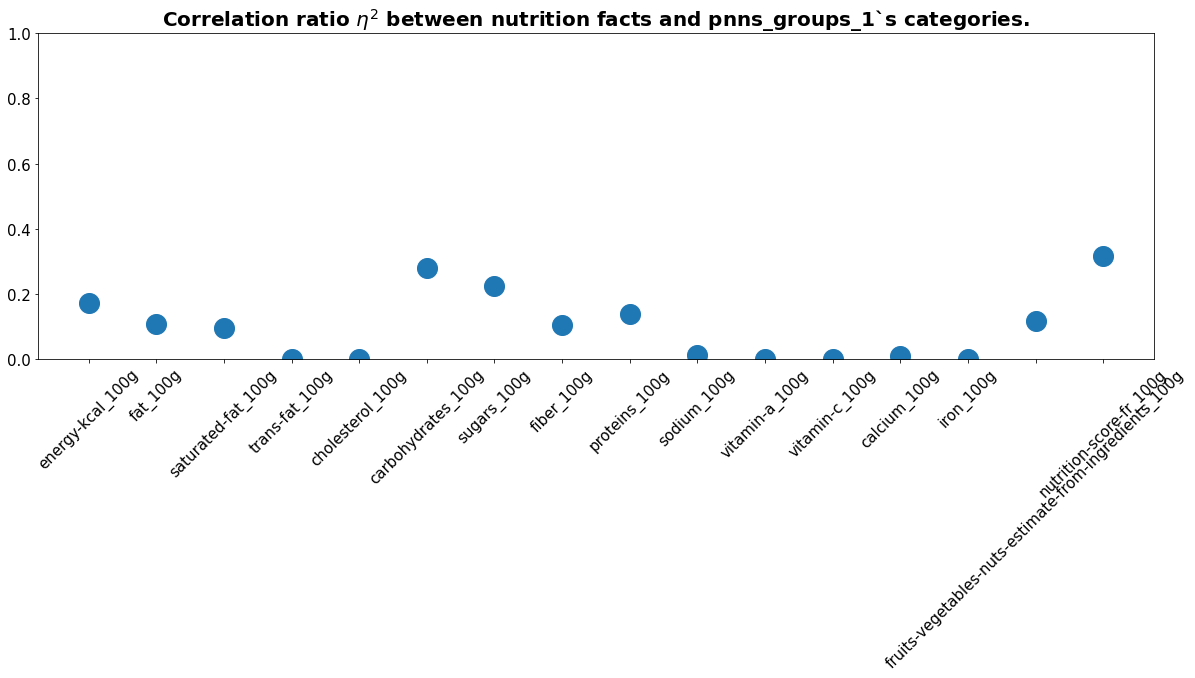

In [19]:
x=pd.Series(dict(zip(df_100g.columns, tab_eta_carre))).index
y=pd.Series(dict(zip(df_100g.columns, tab_eta_carre)))
plt.figure('eta carre = f(pnns_1)', figsize=(20,6))
plt.title(r'Correlation ratio $\eta^{2}$ between nutrition facts and pnns_groups_1`s categories.', fontsize=20, fontweight='bold')
plt.plot(x,y, marker='o', markersize=20, linewidth=0), plt.yticks(size=15), plt.ylim([0,1])
plt.xticks(size=15, rotation=45)

### Pour la plupart des paramètres de type nutrition fact, la variation interclasse pèse peu en regard de la variation totale.
### Ca laisse à penser qu'il y a peu de corrélation entre la valeur des catégories de pnns_groups_1 et chacun des paramètres de type 'nutrition facts', si ce n'est peut être pour 
- nutrition-score-fr_100g ;
- cholesterol_100g ;
- carbohydrates_100g
### qui ont tous un rapport de corrélation supérieur à 0,2 mais inférieur à 0,4.

### Pour nutrition-score-fr_100g, on est capable d'expliquer cela, puisque la construction même du nutriscore crée un lien indirect entre catégorie de produit et valeur du nutriscore.
### On est en revanche plus étonné que des paramètres tels que vitamin-a ou vitamin-c, qui ne prennent des valeurs fortes que pour certains aliments (notamment fruits et légumes), aient une corrélation si basse. 
### L'explication peut en fait venir du grand nombre de zéros : si les valeurs 0 sont précisément attribuées à tous les aliments dépourvus de vitamines A et C (soit, on l'imagine, la majorité des catégories de pnns_groups_1) alors ces catégories ont des moyennes de vitamine A et C très similaires (et quasi nulles), et font donc plonger le rapport de corrélation.

### 
### <u>3.2.3) Matrice de corrélation des nutritions facts.</u>
### A defaut de trouver facilement des corrélations entre des catégories de pnns_groups_1 et des paramètres de type nutrition_facts, on se penche sur l'existence de corrélations ENTRE paramètres de type nutrition_facts.
### On affiche à cet effet la matrice de corrélations entre ces paramètres :

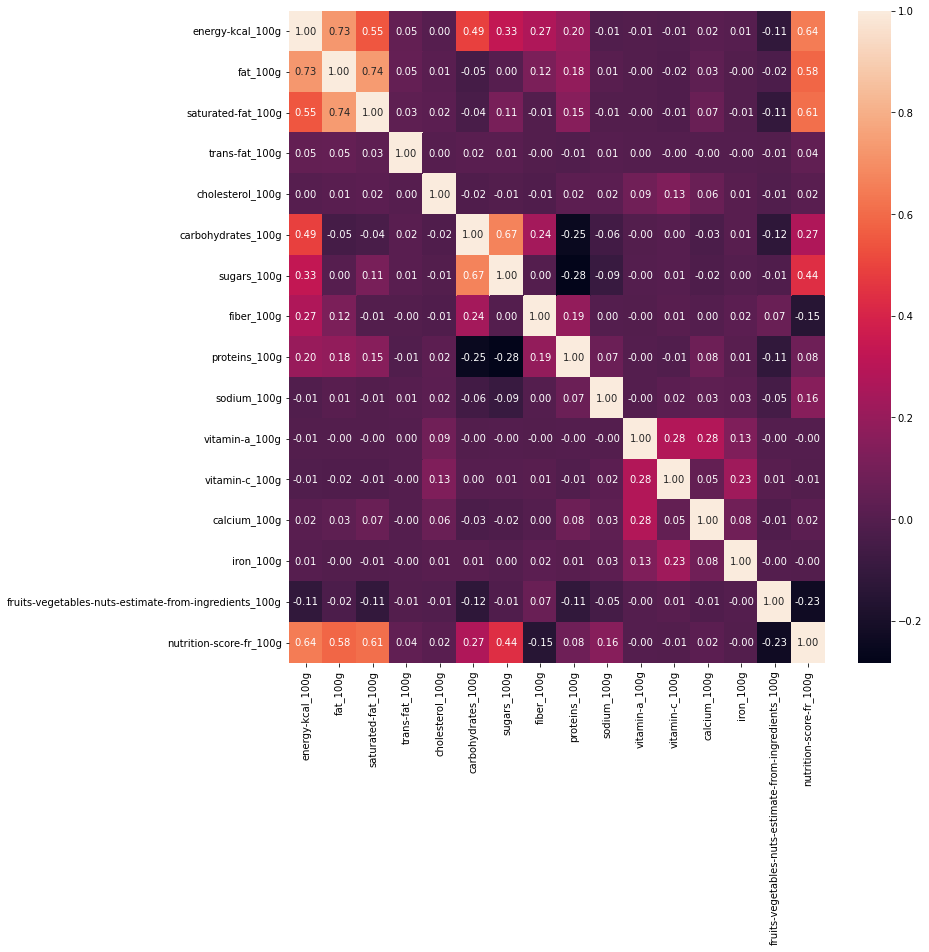

In [20]:
plt.figure(figsize=(12,12))
sns.heatmap(df_100g.corr(), annot=True, fmt='.2f')

### La plupart des coefficients de la matrice sont proches de 0, ce qui signifie qu'il y a peu de corrélations entre la plupart des paramètres de type nutrition facts.
### Décrivons quelques excéptions notables :
- très forte corrélation (0,74) entre fat_100g et saturated-fat_100g, ce qui semble assez logique, puisque les graisses saturées... font partie des graisses ;
- nutrition-score-fr_100g est en corrélation assez forte avec ces deux paramètres et même (dans une moindre mesure) avec sugars_100g ; en effet, tous ces nutriments sont, a priori, à consommer avec grande modération, il est donc logique qu'ils fassent gonfler le nutriscore ;
- au contraire, la plus forte 'corrélation négative' (bien qu'elle soit à relativiser) est entre proteins_100g et sugars_100g ; en effet, même en tant que néophyte en nutrition, on s'attend à ce qu'il y ait peu de sucre dans les aliments protéïnés usuels, et réciproquement.

### 
### <u>3.2.4) Corrélation absolue et cumulée.</u>
### Afin de faire le lien entre l'analyse ANOVA précédente et cette matrice de corrélation, on tente le calcul d'une grandeur non usuelle, afin de savoir si la nature de pnns_groups_1 influe sur l'ensemble des corrélations entre nutrition facts.
### (En regard de l'analyse ANOVA et de la matrice de corrélation, on s'attend à ça ne soit pas, ou peu, le cas).

### Pour chaque catégorie de pnns_groups_1, on calcule la somme cumulée de tous les indices de la matrice de corrélation des paramètres 'nutrition facts' (sauf nutrition-score-fr_100g, car sinon, les boissons alcoolisées ne sont pas prises en compte).
### On prend la valeur absolue afin que les corrélations négatives ne compensent pas les corrélations positives.
### On retire les contributions de la diagonale, et on divise par deux, pour obtenir le poids 'réel' des contributions :
- en effet, la matrice est diagonale et symétrique, donc une des deux matrices triangulaire suffit ;
- les coeffcients sur la diagonales valent systématiquement 1 par définition de la matrice de corrélation.

In [21]:
tab_cumsum_abs_corr = []
for pnns1 in df_pnns['pnns_groups_1'].unique():
    # On se prépare à restreindre la matrice de corrélation aux individus qui sont de la catégorie pnns1, et on retire le paramètre nutrition-score-fr_100g
    df_matrice = df_100g.where(df_pnns['pnns_groups_1']==pnns1).drop(columns='nutrition-score-fr_100g')
    # Calcul de la somme cumulée des valeurs absolues des coefficient d'une des deux matrices triangulaires
    cumsum_abs_corr = ((abs(df_matrice).corr()).cumsum().cumsum(axis=1).loc[df_matrice.columns[-1]].loc[df_matrice.columns[-1]]-df_matrice.shape[1])/2
    # Rangement dans un tableau prévu à cet effet
    tab_cumsum_abs_corr.append(cumsum_abs_corr)
# Création d'un dictionnaire dont les clefs sont les catégories que peut prendre pnns_groups_1    
dict_cm_ab_cr = dict(zip(df_pnns['pnns_groups_1'].unique(), tab_cumsum_abs_corr))

### On affiche les valeurs de ces sommes cumulées, en les exprimant en pourcentage de la valeur maximale possible [ie : si tous les coefficients valent -1 ou 1, soit une corrélation maximale entre tous les paramètres] :

In [22]:
max_possible = (df_matrice.shape[1]-1)*df_matrice.shape[1]/2
for pnns1 in dict_cm_ab_cr.keys():
    pourcentage =100*dict_cm_ab_cr[pnns1]/max_possible
    print(f'Pour la catégorie {pnns1}, la somme cummulée des coefficents absolus de corrélation vaut {pourcentage : .1f} du maximum possible.')

Pour la catégorie unknown, la somme cummulée des coefficents absolus de corrélation vaut  4.9 du maximum possible.
Pour la catégorie Composite foods, la somme cummulée des coefficents absolus de corrélation vaut  7.6 du maximum possible.
Pour la catégorie Sugary snacks, la somme cummulée des coefficents absolus de corrélation vaut  4.0 du maximum possible.
Pour la catégorie Milk and dairy products, la somme cummulée des coefficents absolus de corrélation vaut  4.6 du maximum possible.
Pour la catégorie Fish Meat Eggs, la somme cummulée des coefficents absolus de corrélation vaut  7.9 du maximum possible.
Pour la catégorie Cereals and potatoes, la somme cummulée des coefficents absolus de corrélation vaut  7.1 du maximum possible.
Pour la catégorie Salty snacks, la somme cummulée des coefficents absolus de corrélation vaut  6.1 du maximum possible.
Pour la catégorie Beverages, la somme cummulée des coefficents absolus de corrélation vaut  10.3 du maximum possible.
Pour la catégorie Frui

### On affiche ces pourcentage sous la forme d'un graphe :

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 <a list of 11 Text major ticklabel objects>)

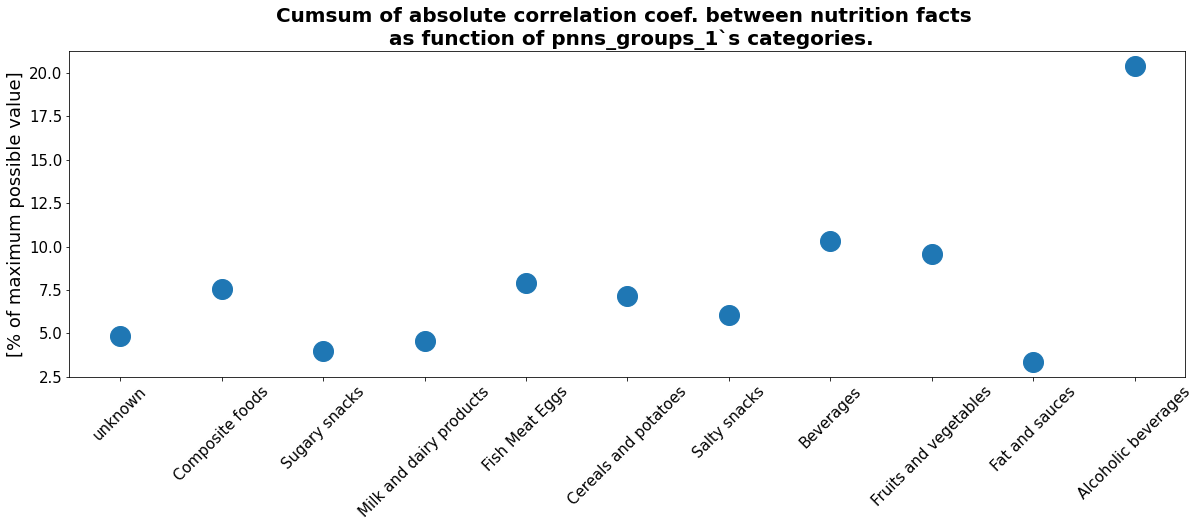

In [23]:
x=pd.Series(dict_cm_ab_cr).index
y=pd.Series(dict_cm_ab_cr)*100/max_possible
plt.figure('cumsum abs corr = f(pnns_1)', figsize=(20,6))
plt.title('Cumsum of absolute correlation coef. between nutrition facts \n as function of pnns_groups_1`s categories.', fontsize=20, fontweight='bold')
plt.plot(x,y, marker='o', markersize=20, linewidth=0), plt.yticks(size=15), plt.ylabel('[% of maximum possible value]', fontsize=18)
plt.xticks(size=15, rotation=45)

### Comme redouté, ces pourcentages sont plutôt faibles, et signifie que toutes catégories de groupe pnns 1 (sauf Alcoholic Beverages), il y a globalement peu de corrélation entre les nutrition facts.
### (Et encore, en retirant le nutrisocre, on a contribué à abaisser toutes ces valeurs, vu les coefficients de corrélations relativement importants qu'il faisait avec les autres nutrition facts.)
### Alcoholic Beverages est évidemment l'exception à la règle, ses carcatéristiques chimiques si particulières devant définir des moyennes très différentes des autres catégories pour chaque nutrion fact. Du plus, son faible nombre de valeurs non NaN ne doit pas contribuer à lisser ses distributions au sein des pralmaètres nutrition facts.

### 
### <u>3.2.5) Analyse par compsante principale (PCA).</u>
### On se propose enfin de compléter cette analyse multi-variée par une analyse en composantes principale de notre jeu de données, en s'inspirant notamment de ce qui a été fait dans le corrigé du webinaire d'OpenClassrooms 'Interprétez des tendances à l'aide de graphiques'.
### Ce webinaire, son énoncé et son corrigé, se trouvent en ressources de ce projet n°2 (le notebook du corrigé est téléchargeable ici https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Webinars/Data/Ao%C3%BBt_2021/corrige%CC%81.ipynb)

### On commence donc, sur le modèle du corrigé, par transformer notre matrice de feautures, via le module StandardScaler(), de telle sorte que :
- sa moyenne devient nulle ;
- son écart-type devienne égal à 1.

In [24]:
### Création de variables qui subbiront les transformations et surlesquelles s'appuiera la PCA
# On définit une variable X = à notre matrice de paramètres (ie : les 16 nutrition facts)
Xpca = df_100g.drop(axis=1,columns='nutrition-score-fr_100g')
# On lui hôte les lignes comportant au moins une NaN
Xpca = Xpca.dropna(axis=0, how='any')
# On retire les lignes contenant, pour chaque paramètre, les 100 valeurs les plus grandes
for s in Xpca.columns :
    index_a_enlever = Xpca[s].sort_values()[-100:].index
    Xpca = Xpca.drop(index_a_enlever)
# On crée une variable = à la liste des intitulés de ces paramètres 
acp_vars = list(Xpca.columns)
# On crée une varibale = aux indices des lignes conservées après suppression des NaN
keep_ind = Xpca.index
### On applique enfin la transformation 'standard'
Xpca = StandardScaler().fit_transform(Xpca)

In [25]:
### Application de la PCA à X
# Initialisation en spécifiant le nombre de dimensions de l'espace des variables
pca = decomposition.PCA(n_components=len(acp_vars))
# Création des vecteurs composante principale
pca.fit(Xpca)
# On projette X dans ce nouvel espace
Xpca = pca.transform(Xpca)

### On affiche l'éboulis des valeurs propres correspondant à cette PCA :

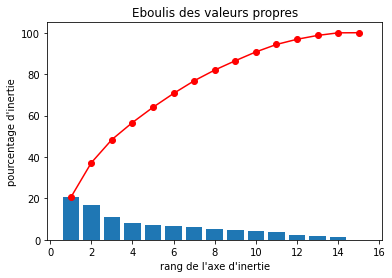

In [26]:
display_scree_plot(pca)

### C'est un résultat mitigé, on voit que l'intertie décroît finalement assez lentement avec le rang des axes trouvés par la PCA. 
### De fait, le premier plan factoriel contient moins de 40% de l'inertie totale, et il faut donc s'attendre à ce qu'il ne suffise pas à bien décrire l'espace des variables. 
### On calcule d'ailleurs le nombre de ces axes respectant le critère de Kaiser :

In [27]:
nb_vecteurs_Kaiser = sum(pca.explained_variance_ratio_>1/len(pca.explained_variance_ratio_))
print(f'Il y a {nb_vecteurs_Kaiser} vecteurs résultant de la PCA qui respectent le critère de Kaiser.')
print(f'Il faut donc s`attendre à avoir besoin au moins des {int(nb_vecteurs_Kaiser/2)} premiers plans factoriels pour pouvoir espérer décrire l`espace des variables.')

Il y a 6 vecteurs résultant de la PCA qui respectent le critère de Kaiser.
Il faut donc s`attendre à avoir besoin au moins des 3 premiers plans factoriels pour pouvoir espérer décrire l`espace des variables.


### On affiche donc le cercle des corrélations, et le nuage de points des individus projetés, sur les espaces factoriels précédents.

<Figure size 432x288 with 0 Axes>

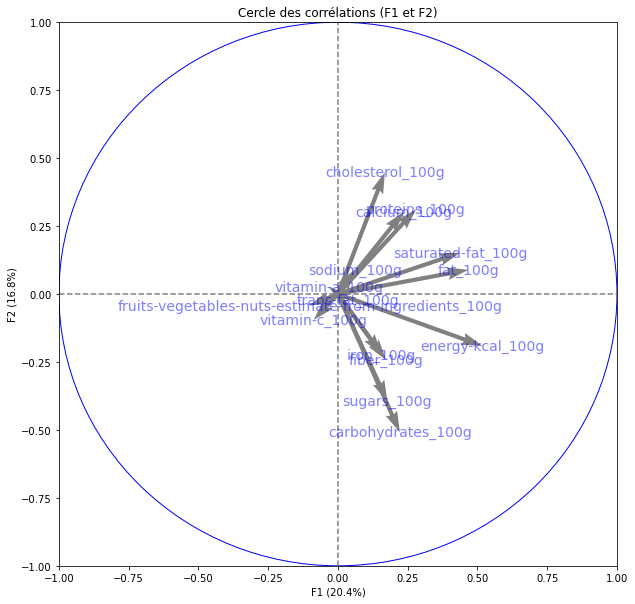

<Figure size 432x288 with 0 Axes>

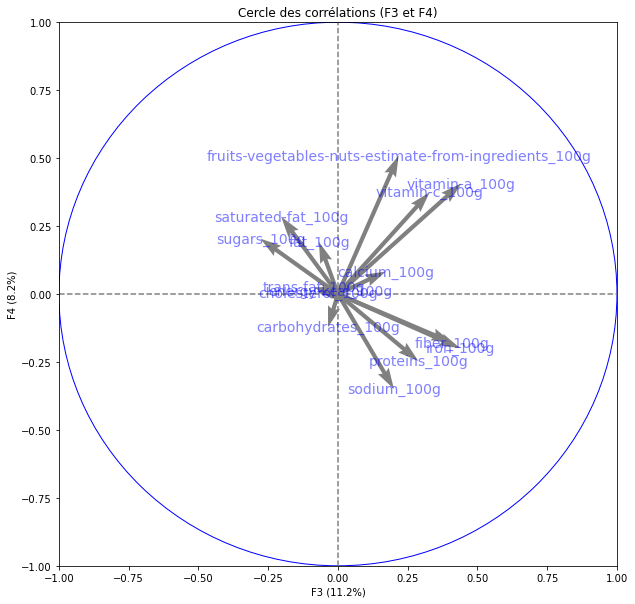

<Figure size 432x288 with 0 Axes>

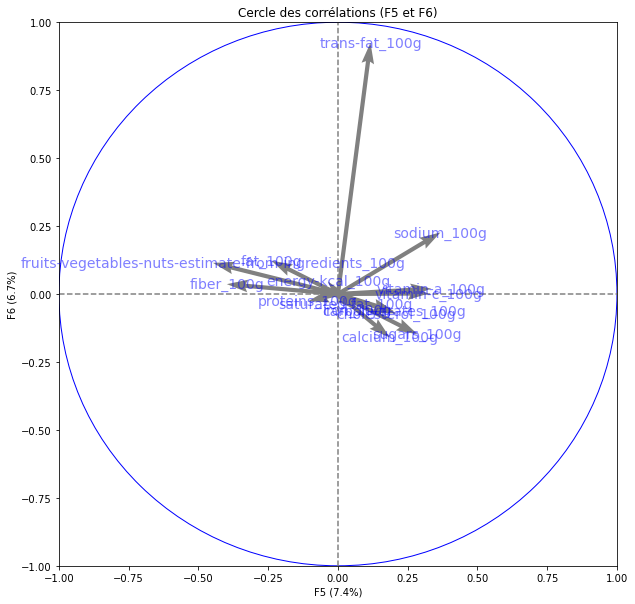

In [28]:
pcs = pca.components_
for i,j in zip(range(0,nb_vecteurs_Kaiser,2), range(1,nb_vecteurs_Kaiser,2)):
    plt.figure(f'Plans factoriels, cercle correlation, ({i},{j})'), plt.clf()
    display_circles(pcs, nb_vecteurs_Kaiser, pca, [(i,j)], labels = np.array(acp_vars))

### Ces trois cercles ne sont pas simples à interpréter.
### Pour le premier : 
- il semblerait que l'axe F1 contienne de l'information en rapport avec la richesse de l'aliment, puisque les paramètres energy-kcal_100, fat_100g, saturated_fat_100g et nutrition-score-fr_100g (soit les almiments caloriques, contenant des graisses, des graisses saturées, et avec un nutriscore élevé) lui sont les paramètres les plus corélés positivement ;
- l'axe F2 est encore plus difficle à déchiffrer, en tout cas pour un néophyte en nutrition.

### Pour le deuxième, on a presque l'impression que les axes sont mal choisis, tant on croit voir se dessiner deux direction orthogonales en dehors des deux axes F3 et F4. A défaut de pouvoir expliquer ces axes, on est soulagé de voir vitamin-a_100g, vitamin-c_100g et fruits-vegetables-nuts_100g être corrélées aux mêmes directions, puisqu'on s'attend à ce que ce soit dans les fruits et les légumes qu'on trouve le plus de ces nutriments (si ce n'est en exclusivité).

### Pour le troisième, l'information principale à retenir est que trans-fat_100g porte quasiment toute l'interie de F6, ce qui explique pourquoi ce paramètre était si mal projeté sur les 1er et 2nd plans factoriels.

### On affiche ensuite les projections des individus sur les plans factoriels précédents.

<Figure size 432x288 with 0 Axes>

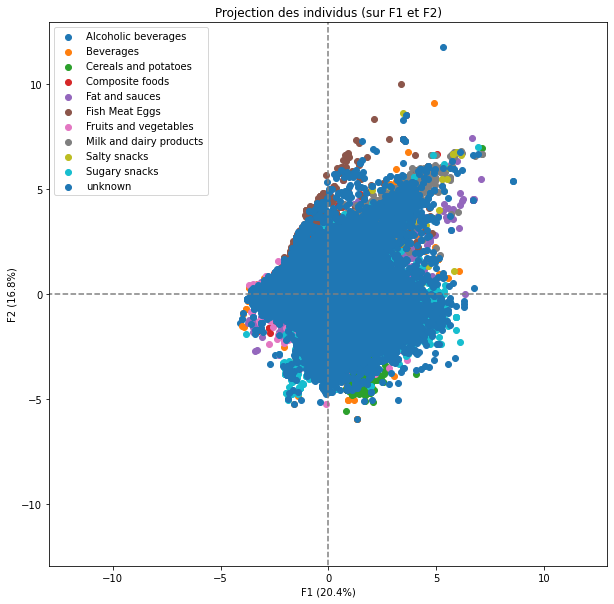

<Figure size 432x288 with 0 Axes>

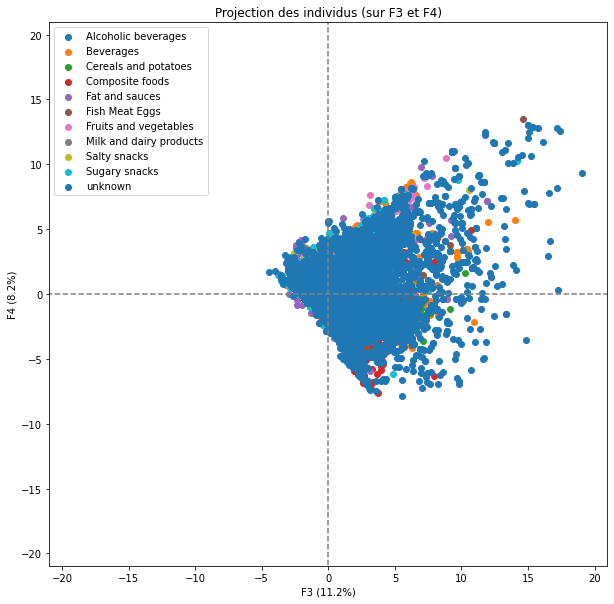

<Figure size 432x288 with 0 Axes>

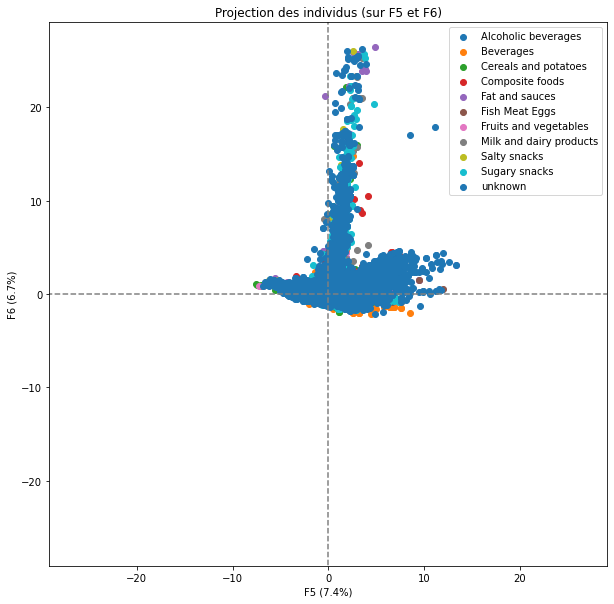

In [29]:
for i,j in zip(range(0,nb_vecteurs_Kaiser,2), range(1,nb_vecteurs_Kaiser,2)):
    plt.figure(f'Plans factoriels, projection individus({i},{j})'), plt.clf()
    display_factorial_planes(Xpca, nb_vecteurs_Kaiser, pca, [(i,j)], illustrative_var=df_pnns['pnns_groups_1'].loc[keep_ind])

### La lecture est rendue difficile par l'écrasante majorité des individus de catégorie 'unknown'. 
### Prenons le temps d'afficher séparemment les individus sur ces plans factoriels selon leur catégorie pnns_groups_1 afin d'y voir plus clair :

<Figure size 432x288 with 0 Axes>

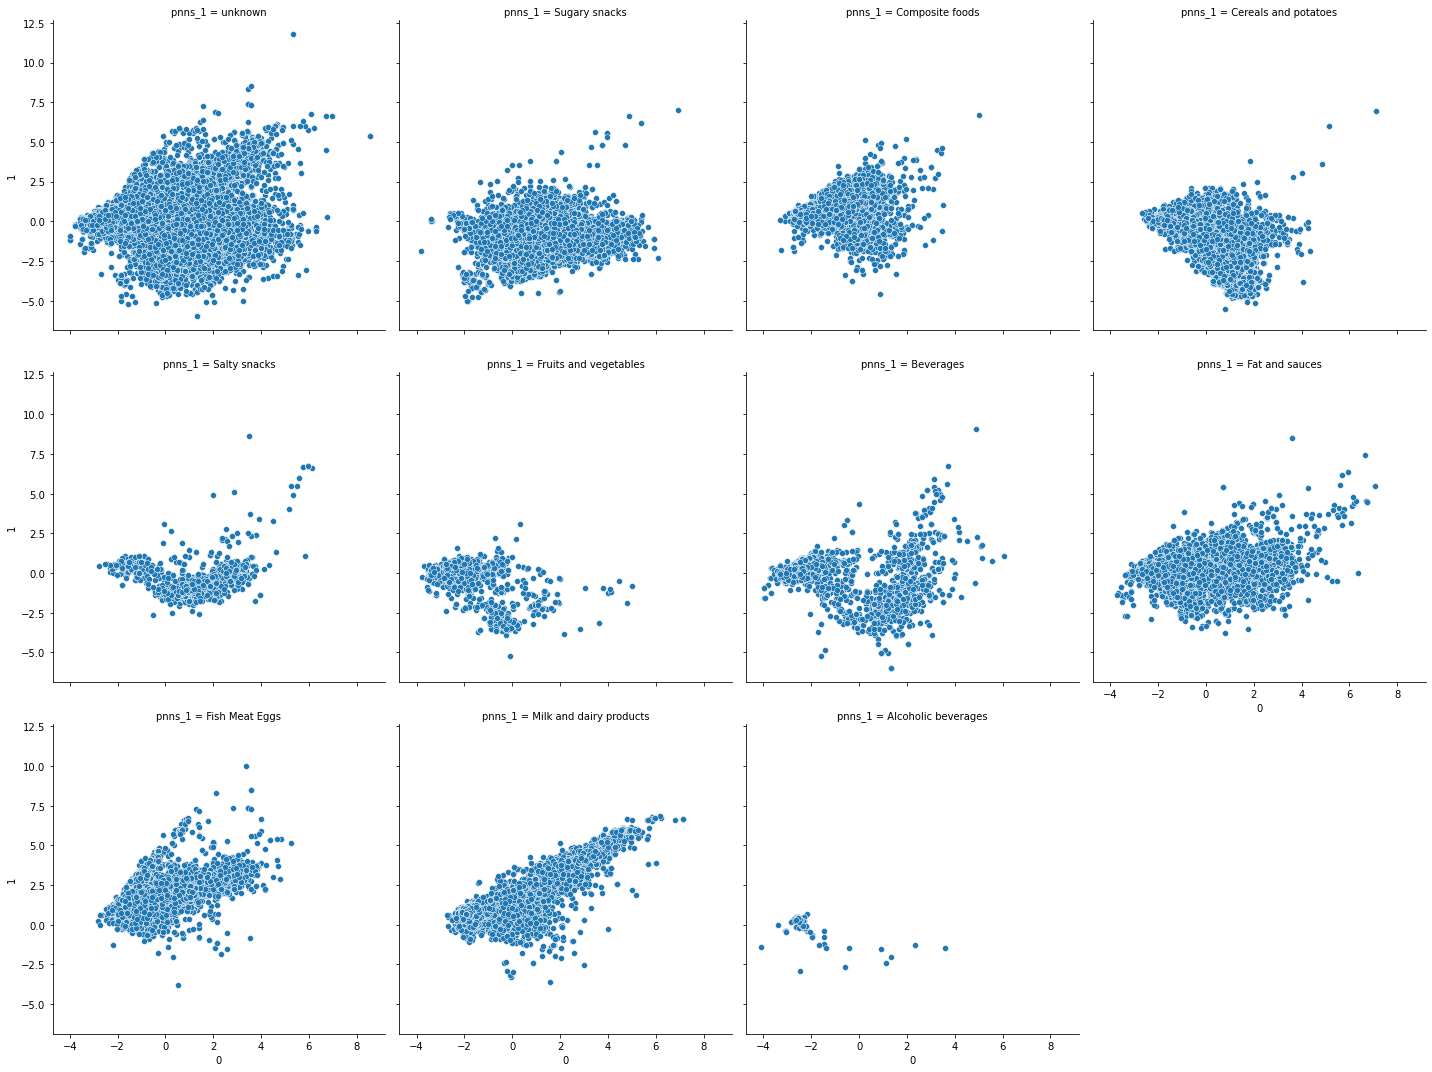

<Figure size 432x288 with 0 Axes>

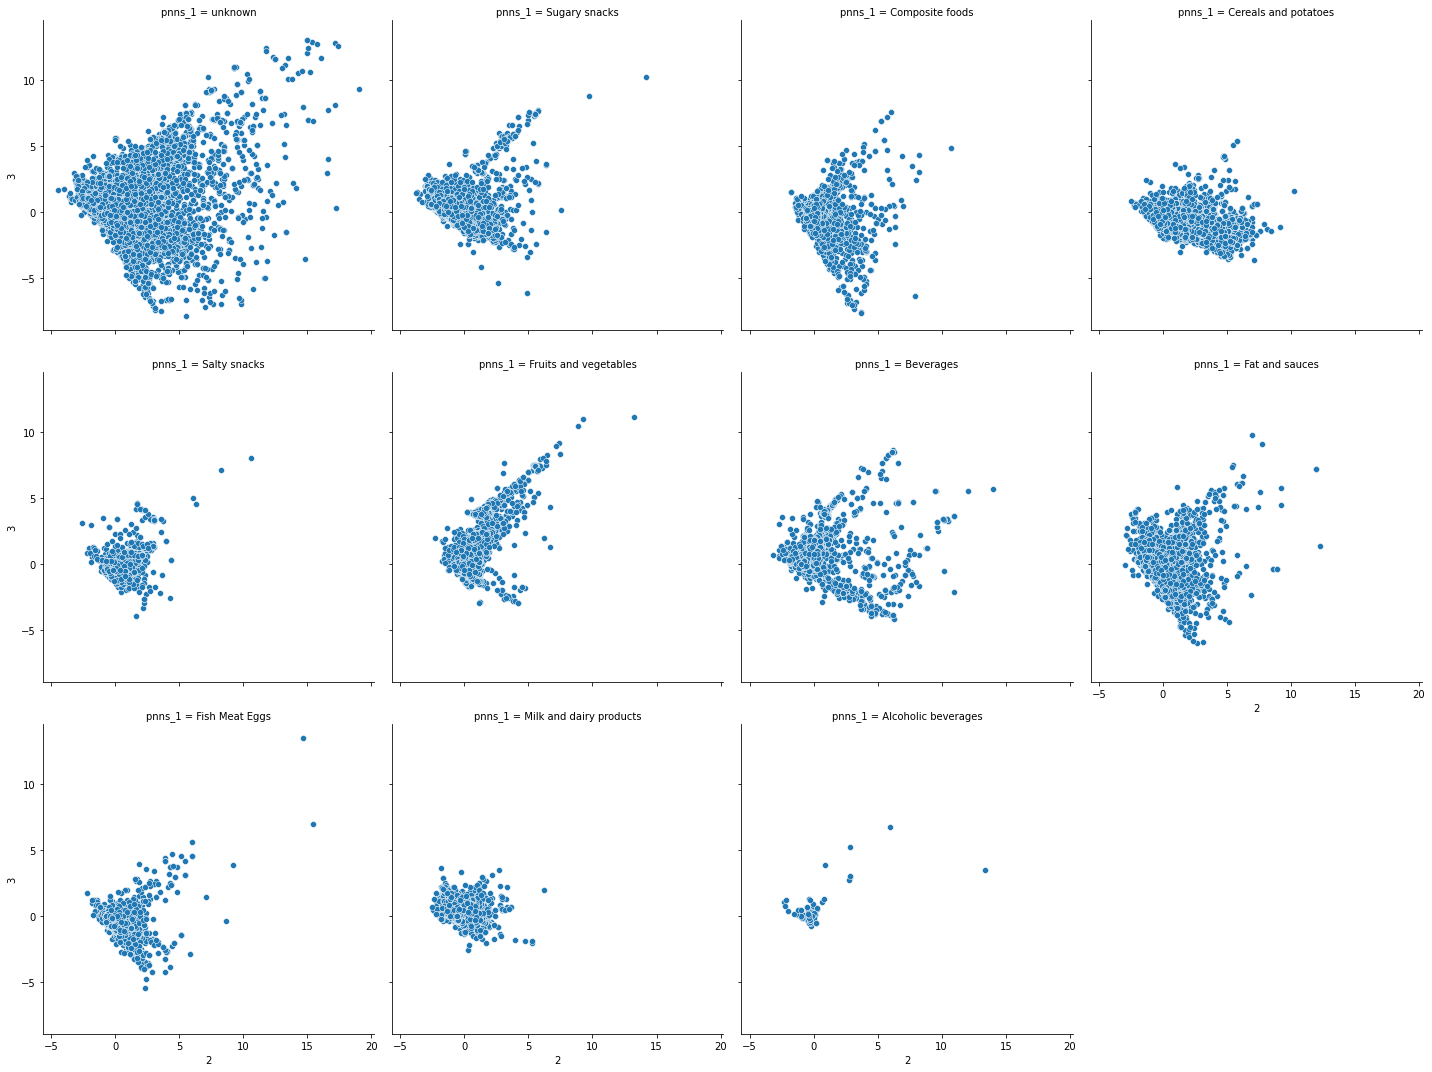

<Figure size 432x288 with 0 Axes>

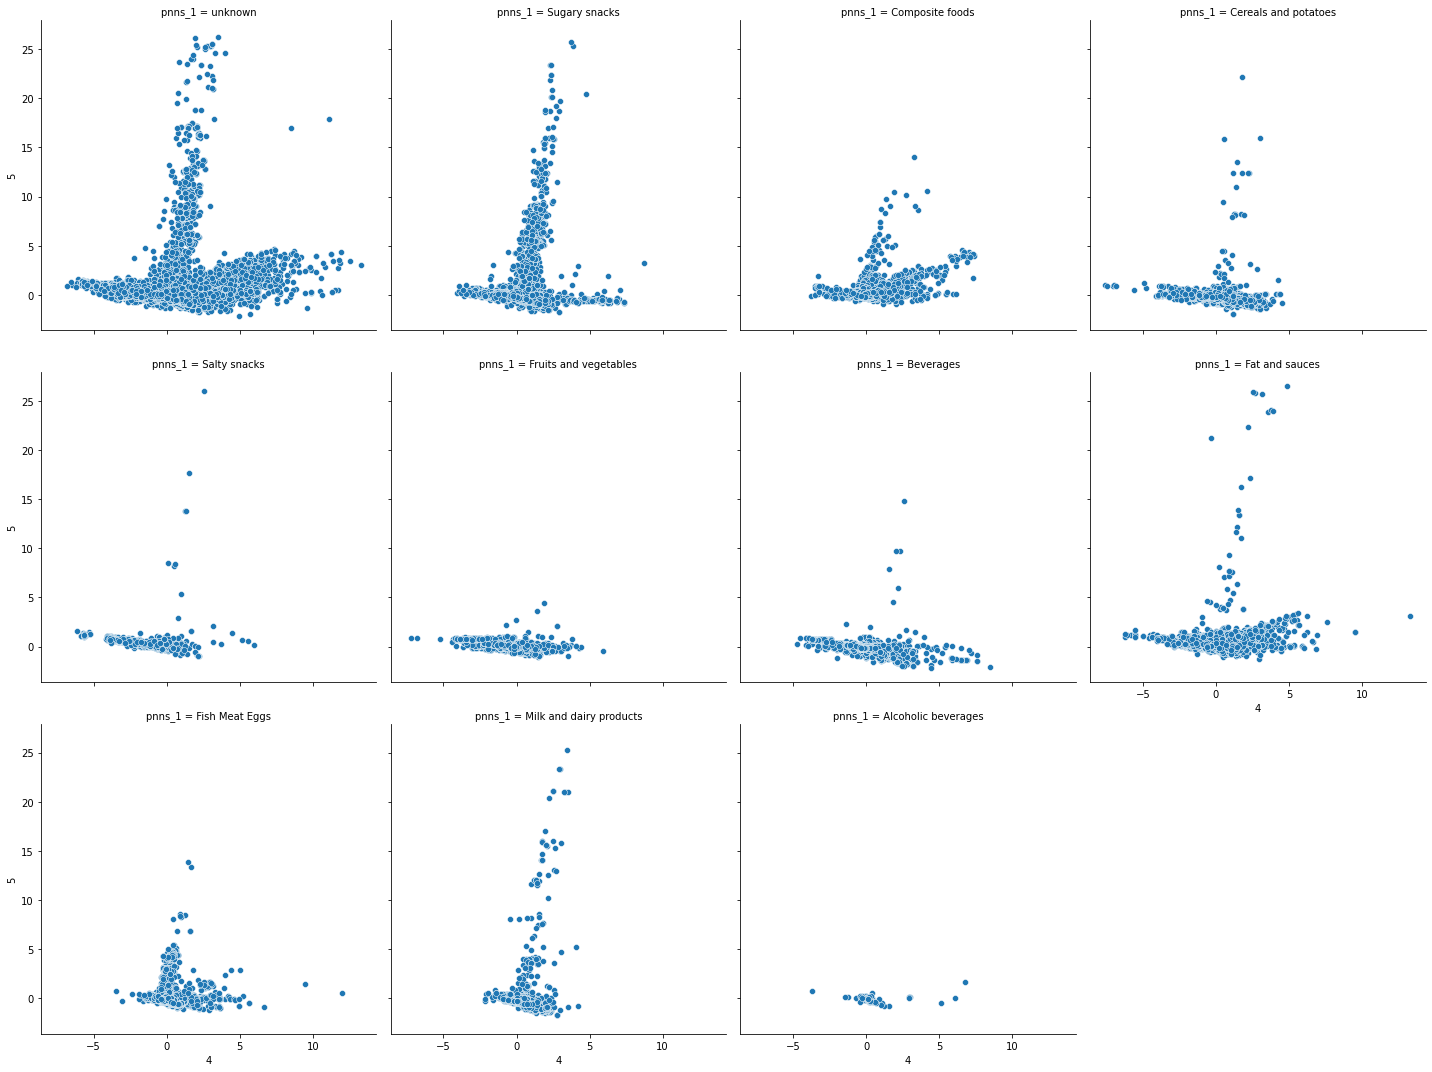

In [30]:
# création d'un pandas.Dataframe à partir des coordonnées des nouveaux axes issus de la PCA, et des individus retenus pour faire la PCA
df_pca = pd.DataFrame(Xpca, index=keep_ind)
# On rajoute à ce Dataframe les catégories pnns_groups_1 de ces individus
df_pca['pnns_1'] = df_pnns['pnns_groups_1'].loc[keep_ind]
for i,j in zip(range(0,nb_vecteurs_Kaiser,2), range(1,nb_vecteurs_Kaiser,2)):
    plt.figure(f'Plans factoriels, projection individus separes par pnns1({i},{j})'), plt.clf()
    sns.relplot(data=df_pca, x=i, y=j, col='pnns_1', col_wrap=4)

### La répartition des individus 'unknown' selon toutes les directions des vecteurs de variables (telles que présentées lors des cercles de corrélations) confirme que de nombreuses catégories se cache derrière cette étiquette, et que ce n'est pas simplement avec des graphiques, ni des calculs de corrélations qu'on va pouvoir prédire leur valeur.
### Cela justifie encore plus notre volonté de recourrir à un algorithme.
### 
### On notera que plusieurs des autres catégories présentent des distributions spatiales plus localisées, et plus caractéristqieus, que celle de la catégorie 'unknown'. Cela prouve qu'on a bien fait d'avoir recours à cette PCA, car elle va pouvoir nous aider à mieux discriminer ces différentes catégories.


# 
# <u>4) Machine learning.</u>
## 
## <u>4.1) Trouver à quelles catégories peuvent être associées chaque valeurs 'unknown' du paramètre pnns_groups_1.</u>
### On a déjà expliqué qu'il y avait énormément de valeurs 'unknown' prises par les paramètres de catégorisation, à savoir les deux pnns_groups. 
### Supérieur à 50% du nombre de lignes de la b2d initiale, il nous faudrait réussir à leur ré-attribuer une valeur parmis les autres valeurs prises par les deux groupes pnns, afin de pouvoir considérablement enichir le choix de l'algorithme régissant l'application.
### On se propose donc d'utiliser des algorithmes de machine learning pour réussir cette exercice de classification : à partir des valeurs prises par les nutrition facts pour chaque catégorie connue des groupes pnns, on peut nourrir un algorithme de clustering pour déduire les propabilités pour un élément de catégorie unkown d'appertenir à chacune d'entre elles.
### 
### <u>4.1.2) Définitions des jeux de données, d'entraînement, d'apprentissage, de validation.</u>

### À partir de l'ennoncé précédent, on déduit donc que :
- les targets seront les groupes pnns 1 ou 2, dont les éléments prennent une valeur différente de 'unknown'
- les features seront le sous Dataframe ne contenant que les nutritions facts (à savoir tous les paramètres terminant par le suffixe _100g), restreints aux mêmes indices que les targets.

### On note qu'on sépare pour l'instant les groupes pnns en deux targets différentes (alors que les valeurs prises par les groupes pnns 2 dépendent de celles prises par les groupes pnns 1), car cherche d'abord à éprouver notre méthode sur un plus petit nombre de catégories (donc sur les groupes de type 1) avant d'utiliser cette méthode sur un nombre de catégorie plus large (donc sur les groupes pnns 2).
### On crée sans plus attendre des variables correspondant à nos features et nos targets.

In [31]:
# Jeux de données (qui feront les jeux d'entraînement, de validation, et de test)
X, y1= df_100g.mask(df_pnns['pnns_groups_1']=='unknown'), df_pnns['pnns_groups_1'].mask(df_pnns['pnns_groups_1']=='unknown')

### 
### <u>4.1.3) Analyse préalable de notre jeu de données : suppression des Nan ou imputation des Nan ?</u>
### Il y a des NaN dans X, et même en très grand nombre, ce qu'un algorithme de machine learning suppervisé ne saura, par définition, pas gérer.
### Il nous faut donc faire un premier choix :
- soit ne travailler qu'avec des éléments non NaN ;
- soit faire une sous imputation pour attribuer une valeur définie à chacune de ces NaN.

### Le premier point est il réalisable ? Regardons combien d'éléments du jeu de données sont complètement définis sur chaque paramètre :

In [32]:
# On définit un sous pandas.Dataframe dépourvu de la moindre NaN à partir de X
XssNaN = X.dropna(axis=0, how='any')
# On calcule le nombre de lignes qu'il reste
nb_lignes_XssNaN = XssNaN.shape[0]
print(f'Si on ne retient que les lignes complètement remplies, il nous en reste {nb_lignes_XssNaN}, soit {100*nb_lignes_XssNaN/X.shape[0]:.1f}% du total avant suppression des NaN.')

Si on ne retient que les lignes complètement remplies, il nous en reste 111513, soit 9.3% du total avant suppression des NaN.


### Un peu de moins de 10% des lignes seraient conservées, ce qui représenteraient tout de même  plus de 111 000 lignes complètement remplies, pour 16 parmètres, soit près de 1 800 000 valeurs définies ! Cela demeurre a priori suffisant pour entrâiner un modèle.
### Néanmoins, il faut nous assurer que cela n'a pas trop dégradé la distribution des valeurs correspondantes prises par les target :

In [33]:
y1.iloc[XssNaN.index].value_counts()

Sugary snacks              26049
Milk and dairy products    16597
Cereals and potatoes       15059
Fat and sauces             13796
Fish Meat Eggs             12966
Composite foods            11749
Fruits and vegetables       8203
Beverages                   5053
Salty snacks                2041
Name: pnns_groups_1, dtype: int64

### Ils contiennent tous plusieurs milliers de valeurs, ce qui demeure satisfaisant dans un premier temps, en terme d'algorithmique.
### En revanche, la catégorie 'Alcoholic beverages' a disparu. C'est dommage, car il n'y a pas de raison a priori que derrière une valeur de type 'unkown' ne se cache pas une boisson alcoolisée.
### Considérons alors une matrice X de feautures qui nous fasse rejeter moins de NaN, en ne tenant plus compte du paramètre nutrition-score-fr_100g. En effet, d'après la description du calcul du nutriscore, les boissons alcoolisées ne sont pas concernées par cette notation :

In [34]:
# On reprend X et on lui retire la colonne en question
X = df_100g.mask(df_pnns['pnns_groups_1']=='unknown').drop('nutrition-score-fr_100g', axis=1)
# On retravaille le sous-dataframe XssNaN en conséquence
XssNaN = X.dropna(axis=0, how='any')
# On observe l'influence de ce changement sur le vecteur y1 :
y1.iloc[XssNaN.index].value_counts()

Sugary snacks              27702
Milk and dairy products    16600
Cereals and potatoes       15127
Fat and sauces             14239
Fish Meat Eggs             12967
Composite foods            11783
Fruits and vegetables       8225
Beverages                   5927
Salty snacks                2041
Alcoholic beverages          105
Name: pnns_groups_1, dtype: int64

### Très bien, la catégorie 'alcoolic beverage' est de retour, bien que nettement moins fournie en valeurs non NaN que les autres catégorie de pnns_groups_1.
### On peut donc passer à l'étape suivante qui est la constituation à partir de ces données des jeux d'entraînement et de test. 
### Avant cela, créons une variable correspondant au vecteur target y1, pour les indices correspondant aux lignes de la matrice de features XssNaN.

In [35]:
y1ssNaN = y1.iloc[XssNaN.index]

### 
### <u>4.1.4) Division du jeu de données en jeux d'entraînement et de test.</u>
### Commençons par extraire 25% du jeu de données pour constituer un jeu de test qu'on réserve pour le moment.

In [36]:
X_trainval, X_test, y_trainval, y_test = train_test_split(XssNaN, y1ssNaN)

### On s'assure que le split n'a pas trop altéré la distribution des catégories du groupe pnns 1 au sein des deux jeux :

In [37]:
y_trainval.value_counts()

Sugary snacks              20743
Milk and dairy products    12519
Cereals and potatoes       11342
Fat and sauces             10708
Fish Meat Eggs              9688
Composite foods             8780
Fruits and vegetables       6215
Beverages                   4445
Salty snacks                1515
Alcoholic beverages           82
Name: pnns_groups_1, dtype: int64

In [38]:
y_test.value_counts()

Sugary snacks              6959
Milk and dairy products    4081
Cereals and potatoes       3785
Fat and sauces             3531
Fish Meat Eggs             3279
Composite foods            3003
Fruits and vegetables      2010
Beverages                  1482
Salty snacks                526
Alcoholic beverages          23
Name: pnns_groups_1, dtype: int64

### Nous sommes rassurés
### !!! NB : RELANCER TRAIN_TEST_SPLIT SI CE N'EST PAS LE CAS, JUSQU'À OBTENTION D'UNE DIVISION SATISFAISANTE !!!
### !!! (PUIS FIXER LE PARAMETRE RANDOM_STATE DU TRAIN_TEST_SPLIT POUR NE PLUS FAIRE VARIER LA DIVISION) !!!

### 
### <u>4.1.5) Préparation d'une validation croisée.</u>
### On va maintenant préparer une validation croisée respectant la distribution de catégories des groups_pnns_1 grâce à la méthode des plis stratifiés, qui va nous permettre de définir plusieurs plis de jeux d'entraînement et de jeux de validation correspondants.

In [39]:
# Initialisation (par défaut, StratifiedKFold fera 5 plis)
strat_cv = StratifiedKFold()
# Initialisation de listes qui contiendront les indices des différents plis : une pour les jeux d'entraînement, une pour les jeux de validation :
tab_indx_train, tab_indx_val = [], []
# On remplit ces listes
for train, test in strat_cv.split(X_trainval, y_trainval):
    tab_indx_train.append(train), tab_indx_val.append(test)
# On les convertit en tableaux
tab_indx_train, tab_indx_val = np.array(tab_indx_train), np.array(tab_indx_val)

### 
### <u>4.1.6) Algorithme de classification.</u>
### Du fait de la nature des feautures et du vecteur target, on choisit d'employer un algorithme de type 'K plus Proches Voisins (K Nearest Neighbours)'.
### 
#### <u>4.1.6.1) Choix du nombre optimal de voisins.</u>
### Afin de trouver rapidement un nombre optimal de voisins, nous allons prendre un seul jeu d'entraînement sur lequel nous allons faire tourner un algorithme k NN en y faisant varier le nomnbre de voisins, puis nous choisirons celui qui produit le meilleur score pour le jeu de validation associé. 
### On sélectionne aléatoirement le pli en question parmis les 5 qu'on a tirés grâce au StratifiedKFold.

In [40]:
# Choix d'un pli au hasard
num_pli = np.random.randint(len(tab_indx_train))
# Indices correspondant à ce pli
indx_train, indx_val = tab_indx_train[num_pli], tab_indx_val[num_pli]
# Selection des jeux d'entraînement correspondants :
X_train, y_train = X_trainval.iloc[indx_train], y_trainval.iloc[indx_train]
# Selection de jeux de validation correspondant
X_val, y_val = X_trainval.iloc[indx_val], y_trainval.iloc[indx_val]

### Puis on fait tourner l'algorithme sur ce pli, en faisant varier le nombre voisins.

In [41]:
# Initialisation de la liste qui contiendra les scores sur le jeux de validation
tab_score = []
# Initialisation de la plage du nombre voisins possible
tab_k_voisins = range(2,15)
# On entraîne et valide le classifieur pour chacun de ces nombres de voisins.
for k in tab_k_voisins :  
    # Initialisation de l'algo
    kNN = KNeighborsClassifier(n_neighbors=k)
    # ENtraînement
    kNN.fit(X_train, y_train)
    # Rangement du score sur le jeu de validation dans la liste
    tab_score.append(kNN.score(X_val, y_val))
# Conversion de la liste en tableau
tab_score = np.array(tab_score)

### On déduit le nombre optimal de voisins pour maximiser le score sur jeu de validation :

In [42]:
# Recherche de cette valeur
k_optimal = tab_k_voisins[np.argmax(tab_score)]
# AFfichage
print(f'Le nombre optimal de voisins est {k_optimal}.')

Le nombre optimal de voisins est 3.


### On retiendra donc ce nombre de voisins.
### 
#### <u>4.1.6.2) Choix du nombre optimal de jobs à faire tourner en parallèle (OPTIONNEL).</u>
### Au passage, on se laisse la possibilité (DESACTIVABLE PAR L'UTILISATEUR S'IL LE SOUHAITE) de trouver également le nombre optimal de jobs à lancer en parallèle pour accélerer cette procédure (car c'est un paramètre optionnel du classifieur à K voisins) ! 
### On se base pour cela sur des lignes de codes similaires au précédentes, en faisaint tourner le même algorithme pour un nombre de jobs différent à chaque itération, et en enregistrant le temps de computation dans une liste.

In [43]:
# Initilisation du nombre de jobs sur sa valeur par défaut
n_jobs_optimal = 1
if Recherche_n_jobs_optimal :
    # Initialisation de la liste qui contiendra les temps de calculs
    tab_time = []
    # Initialisation de la plage du nombre voisins possible
    tab_n_jobs = range(1,10)
    # On entraîne et valide le classifieur avec un nombre optimal de voisins.
    for n_jobs in tab_n_jobs :
        # Déclenchement du chrono
        t_start = time.time()
        # Initialisation de l'algo
        kNN = KNeighborsClassifier(n_neighbors=k_optimal)
        # ENtraînement
        kNN.fit(X_train, y_train)
        # Calcul du score
        kNN.score(X_val, y_val)
        # Arrêt du chrono
        t_stop = time.time() 
        # Rangement de la durée de computation dans la liste
        tab_time.append(t_stop - t_start)
    # Conversion de la liste en tableau
    tab_time = np.array(tab_time)
    # Recherche du nombre de jobs minimisant le temps
    n_jobs_optimal = tab_n_jobs[np.argmin(tab_time)]
    # Affichage
    print(f'Pour un nombre de voisins égal à {k_optimal}, le nombre optimal de jobs à faire tourner en parallèle vaut : {n_jobs_optimal}.')

Pour un nombre de voisins égal à 3, le nombre optimal de jobs à faire tourner en parallèle vaut : 7.


### On démarrera donc autant de jobs en parallèle.
### 
### <u>4.1.7) Validation croisée de l'algorithme</u>
### On applique la validation croisée à l'algorithme de classeur optimisé à ce nombre de voisins, pour le nombre ci-dessus de jobs en parllèle, sur les 5 plis définis préalablement.

In [44]:
kNN_opt = KNeighborsClassifier(n_neighbors=k_optimal, n_jobs=n_jobs_optimal)
tab_scores_trainval = cross_val_score(kNN_opt, X_trainval, y_trainval, cv=strat_cv)
print(f'Pour un classeur à {k_optimal} voisins, tournant sur {n_jobs_optimal} en parllèle, et entraîné\validé sur 5 plis stratifiés :')
print(f'\t- le score sur les jeux de validation vaut en moyenne {np.mean(tab_scores_trainval):>.5f}')
print(f'\t- l`écart-type correspondant vaut {np.std(tab_scores_trainval):>.5f}')
print(f'\t- avec un minimun à {np.min(tab_scores_trainval):>.5f}')
print(f'\t- et un maximun à {np.max(tab_scores_trainval):>.5f}')

Pour un classeur à 3 voisins, tournant sur 7 en parllèle, et entraînéalidé sur 5 plis stratifiés :
	- le score sur les jeux de validation vaut en moyenne 0.85333
	- l`écart-type correspondant vaut 0.00196
	- avec un minimun à 0.84948
	- et un maximun à 0.85478


### Ca pourrait être mieux, mais c'est pas mal. Il reste à soumettre le jeu de test à l'algorithme.
### 
### <u>4.1.8) Test final de l'algorithme sur le jeu de test laissé de côté :</u>

In [45]:
# On recommence par entraîner l'algorithme (car formellement, cela n'a pas été fait par la fonction cross_val_score)
for indx_train in tab_indx_train :
    X_train, y_train = X_trainval.iloc[indx_train], y_trainval.iloc[indx_train]
    kNN_opt.fit(X_train, y_train)
score_test = kNN_opt.score(X_test, y_test)
print(f'Appliqué au jeu de test, l`algorithme produit un score de {score_test:.5f}')

Appliqué au jeu de test, l`algorithme produit un score de 0.85383


### Ca pourrait être mieux, mais on peut s'en contenter dans un premier temps !
# !!! En effet, cela prouve qu'on peut prédire la nature de la catégorie pnns_groups_1 avec un taux d'erreur relativement faible, à partir d'un nombre de nutrition fact assez faible (15, en regard du nombre initial de nutrirtion facts dans la base de donnée non réduite, soit près d'une centaine). D'autant que nous n'avons même pas eu besoin d'un modèle complexe, ni de normaliser des variables d'entrée qui peuvent pourtant prendre des valeurs très différentes (energy-kcal_100g prenant principalement des valeurs entre 100 et 1000, alors que les autres paramètres ne vont jusqu'à 100, et bien souvent prennent des valeurs inférieures à 1...).
### 
### <u>4.1.9) Application pour prédire la catégorisation des groups_pnns_1 de valeur 'unknown'.</u>
### On commence par repérer les nutrition facts correspondants aux groups_pnns_1 prenant comme valeur 'unknown' :

In [46]:
# Variable : sous dataframe des nutrition facts, pour lesquels groups_pnns_1 = unknown, et sans aucune NaN.
X_unknown_ssNan = df_100g.where(df_pnns['pnns_groups_1']=='unknown').drop('nutrition-score-fr_100g', axis=1).dropna(axis=0,how='any')

### Puis on réalise une prédiction à l'aune de l'algorithme :

In [47]:
# Vecteurs des catégories le splus probables pour chaque élément précédent
prediction = kNN_opt.predict(X_unknown_ssNan)
# Matrice des probabilité de la prédiction
matrice_proba = kNN_opt.predict_proba(X_unknown_ssNan)

### On affiche le nombre de fois que chaque autre catégorie est prédite à partir d'un élément initialement 'unknown' :

In [48]:
pd.Series(prediction).value_counts()

Sugary snacks              14443
Composite foods             8159
Cereals and potatoes        7352
Milk and dairy products     6560
Salty snacks                6460
Fat and sauces              5646
Fruits and vegetables       3309
Fish Meat Eggs              3208
Beverages                   2140
Alcoholic beverages           34
dtype: int64

### On crée un sous-dataframe à partir de la matrice de probabilités, afin de pouvoir en faire une description statistique :

In [49]:
df_predictions = pd.DataFrame(data=matrice_proba, columns=kNN_opt.classes_)
df_predictions.describe(percentiles=[0.25, 0.75, 0.9, 0.95])

Alcoholic beverages     Beverages  Cereals and potatoes  \
count         57311.000000  57311.000000          57311.000000   
mean              0.000518      0.031594              0.112980   
std               0.013273      0.145445              0.255751   
min               0.000000      0.000000              0.000000   
25%               0.000000      0.000000              0.000000   
50%               0.000000      0.000000              0.000000   
75%               0.000000      0.000000              0.000000   
90%               0.000000      0.000000              0.333333   
95%               0.000000      0.333333              0.666667   
max               0.666667      1.000000              1.000000   

       Composite foods  Fat and sauces  Fish Meat Eggs  Fruits and vegetables  \
count     57311.000000    57311.000000    57311.000000           57311.000000   
mean          0.134803        0.101034        0.060454               0.062513   
std           0.287927        0.248791        0.210021               0.214232   
min           0.000000        0.000000        0.000000               0.000000   
25%           0.000000        0.000000        0.000000               0.000000   
50%           0.000000        0.000000        0.000000               0.000000   
75%           0.000000        0.000000        0.000000               0.000000   
90%           0.666667        0.333333        0.000000               0.000000   
95%           1.000000        0.666667        0.666667               0.666667   
max           1.000000        1.000000        1.000000               1.000000   

       Milk and dairy products  Salty snacks  Sugary snacks  
count             57311.000000  57311.000000   57311.000000  
mean                  0.115906      0.121291       0.258909  
std                   0.296109      0.291187       0.382737  
min                   0.000000      0.000000       0.000000  
25%                   0.000000      0.000000       0.000000  
50%                   0.000000      0.000000       0.000000  
75%                   0.000000      0.000000       0.666667  
90%                   0.666667      0.666667       1.000000  
95%                   1.000000      1.000000       1.000000  
max                   1.000000      1.000000       1.000000

### On voit que pour chaque catégorie, la moyenne est très faible, et l'écart-type supérieure à celle-ci, car la plupart du temps, la probabilité qui leur est assignée est nulle (ormis les 'sugary snacks', toutes les catégories ont au moins 75% de leurs probabilités assignées nulle).
### A la vue de la ligne du 95ème centile (notamment les valeurs complémentaires 0.333 et 6.667), notre première pensée est que, pour un élément de catégorie 'unknown', la prédiction donne rarement plus que deux possibilités (ie : plus que deux catégories de probabilité non nulle).
### On affiche donc, sous la forme d'une carte de couleur, une cinquantaine de lignes de cette matrice, prises au hasard :

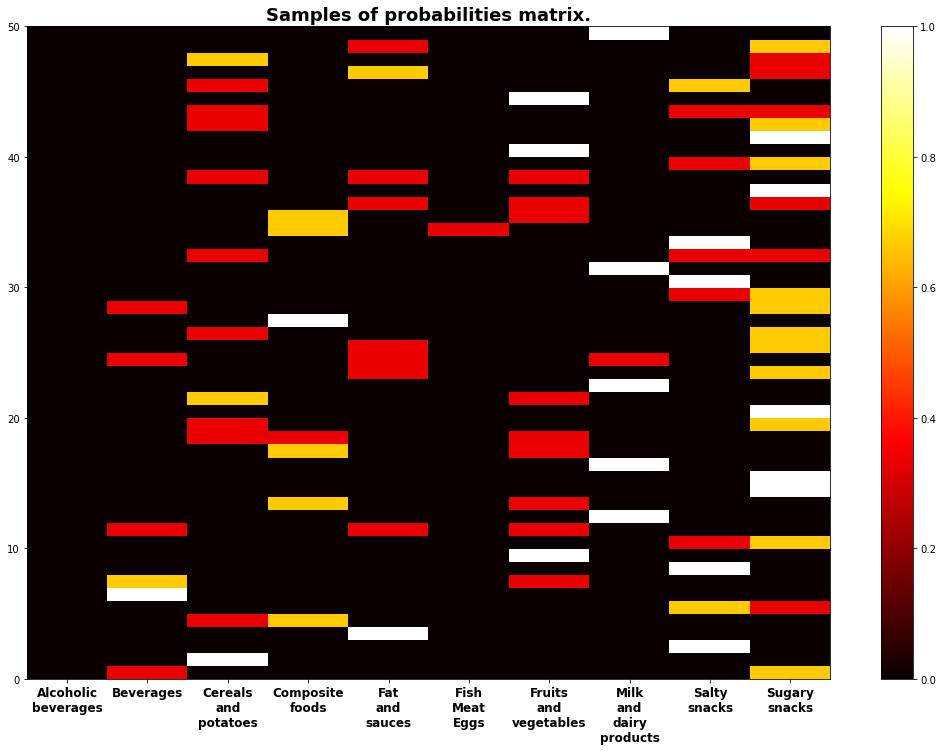

In [50]:
plt.figure('Matrice de prediction', figsize=(18,12)), plt.title('Samples of probabilities matrix.', fontweight='bold', fontsize=18)
xlabel = [label.replace(' ','\n') for label in kNN_opt.classes_.astype(str)]
data = matrice_proba[np.random.randint(matrice_proba.shape[0], size=50)]#df_predictions.corr()
plt.pcolormesh(data, cmap='hot')
plt.xticks(ticks=np.arange(1,11)-0.5, labels=xlabel, fontweight='bold', fontsize=12)
#plt.yticks(ticks=np.arange(1,11)-0.5, labels=xlabel, fontweight='bold', fontsize=12)
plt.colorbar()

### On observe le plus souvent une seule catégorie de probabilité non nulle (et donc égale à 1, soit une prédiction certaine), et pour quelques lignes deux ou trois, et le plus souvent, les valeurs complémentaires sont des multiples d'un tiers.
### On cherche à confirmer cette impression on comptant les différenets occurences de chaque valeurs prises par les probabilité de chaque catégorie :

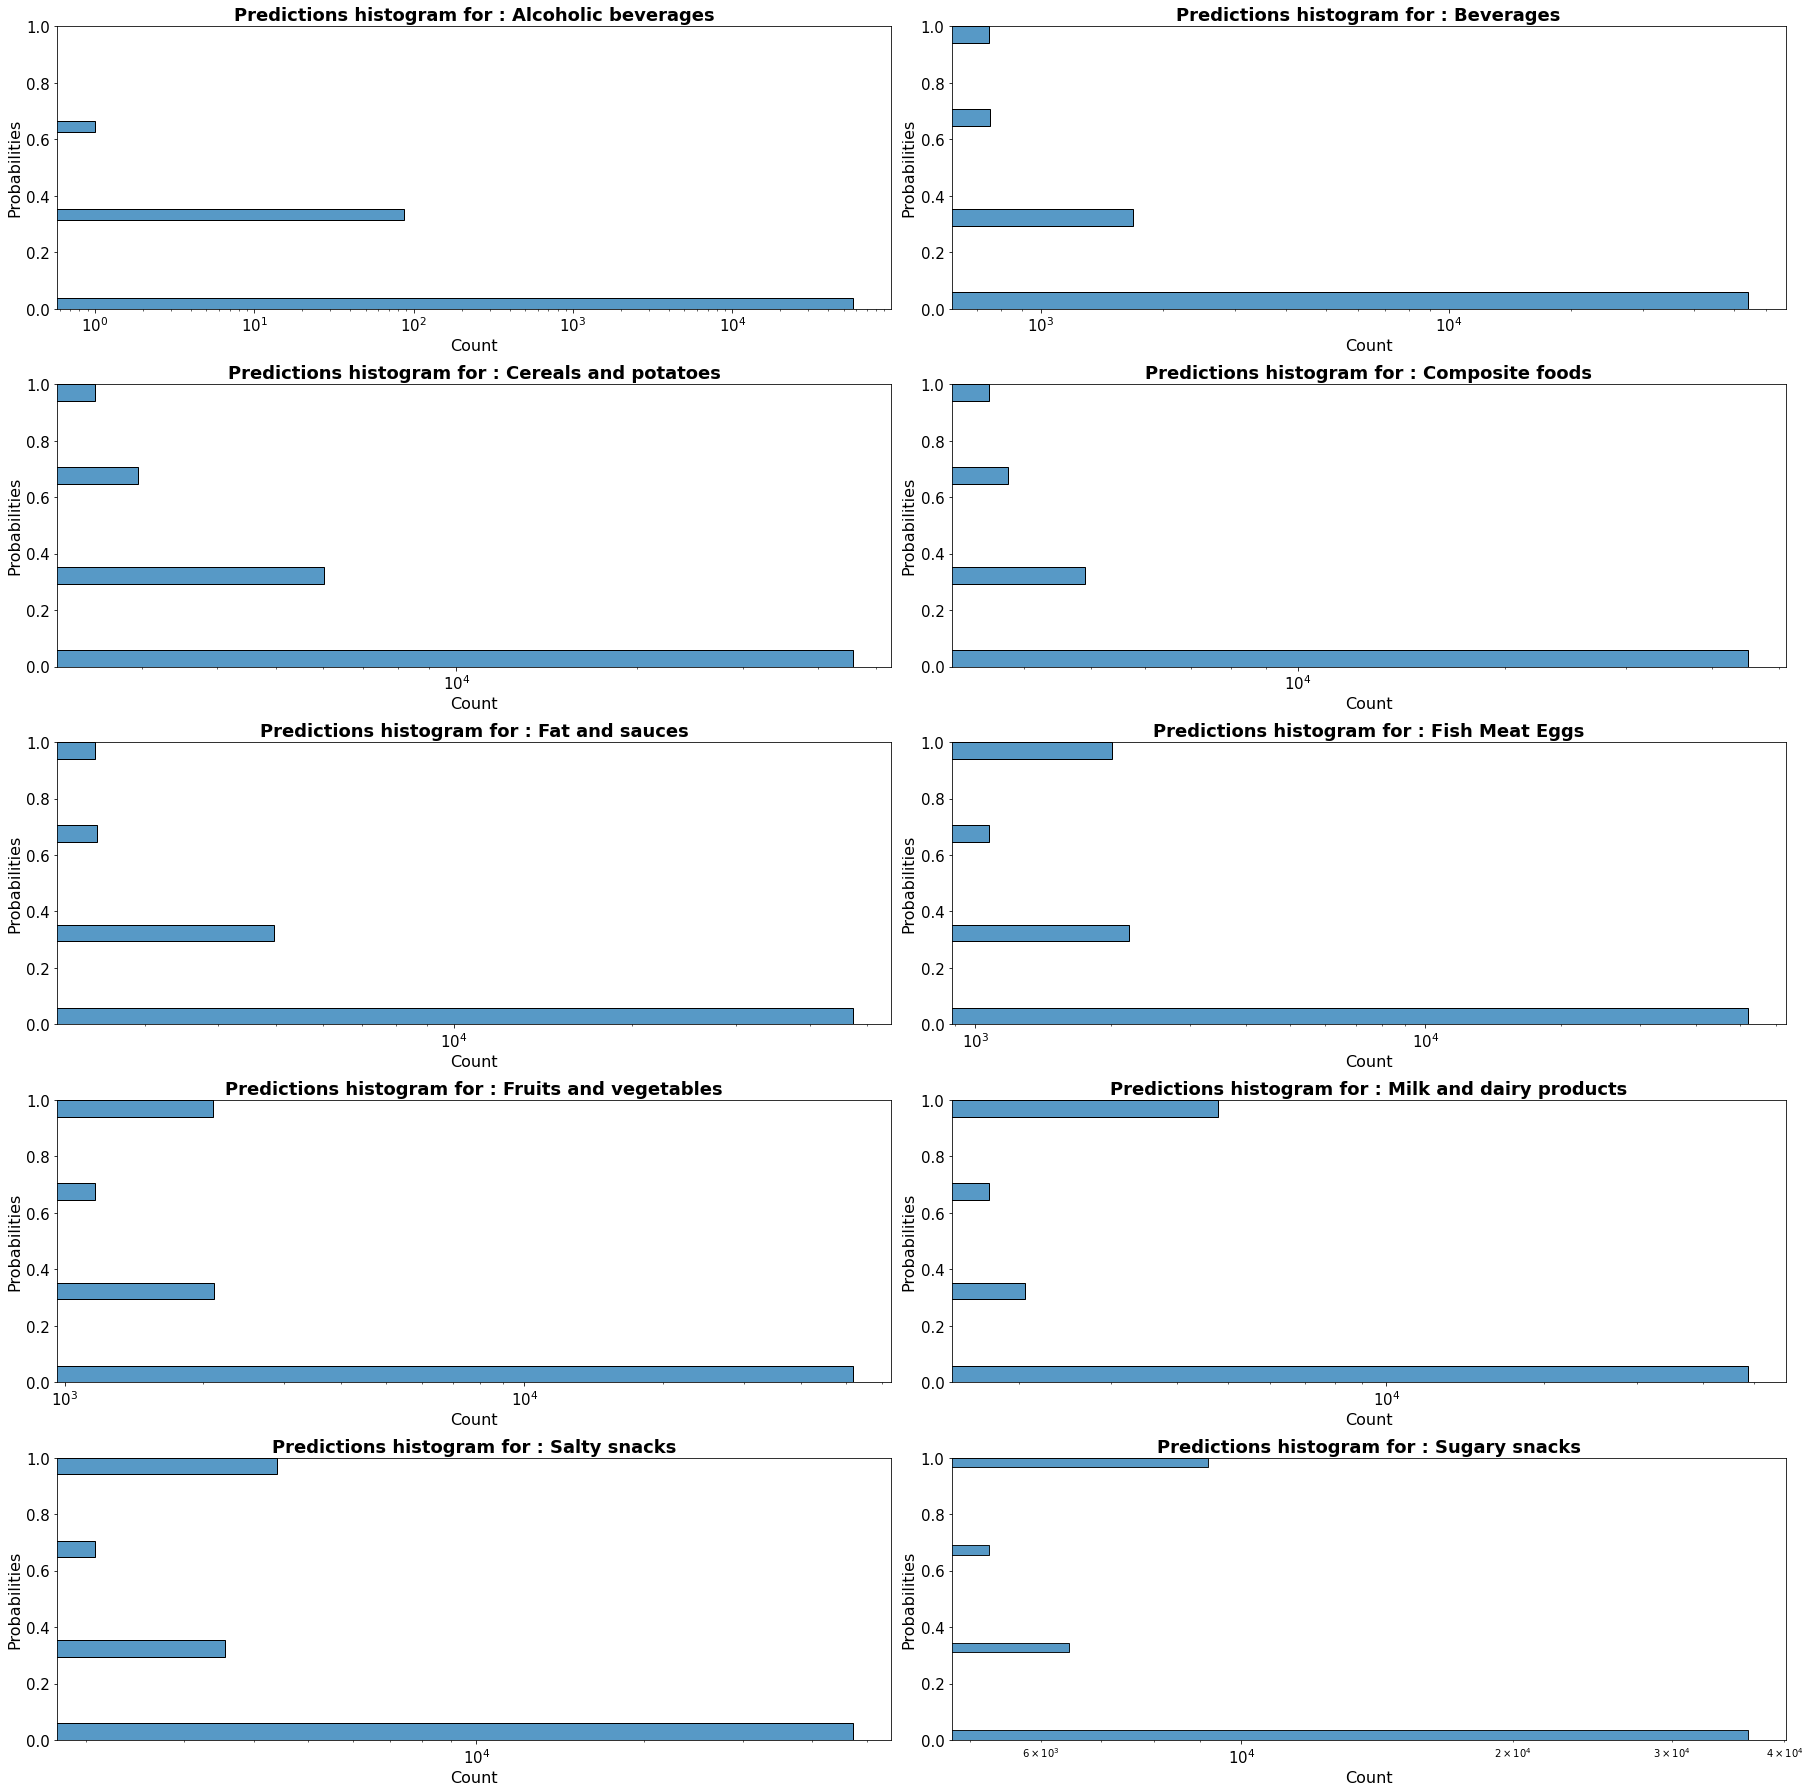

In [51]:
plt.figure('Histogramme des prédictions', figsize=(25,25)), plt.clf(), plt.title('qsdf')
for i, s in enumerate(df_predictions.columns) :
    plt.subplot(5,2,i+1), sns.histplot(y=df_predictions[s])
    plt.ylim([0,1]), plt.yticks(size=15), plt.ylabel('Probabilities', size=16), plt.tight_layout()
    plt.xscale('log'), plt.xticks(size=15), plt.xlabel('Count', size=16)
    plt.title('Predictions histogram for : '+s, fontweight='bold', fontsize=18)

### Cela confirme nos impressions, les valeurs prises par les probabilités appartiennent à l'ensemble suivant : {0; 1/3, 2/3, 1}. 
### Cela tient sans doute au nombre de voisins dans notre algorithme : 3. Dès lors, l'algorithme ne peut pas prédire plus de 3 catégories différentes pour un même individus. 

### On va désormais projeter les prédictions sur les espaces factoriels précédents : (en s'inspirant du corigé du webinaire "interprétez des tendances à l'aide de visualisations", accessible ici : https://s3.eu-west-1.amazonaws.com/course.oc-static.com/projects/Webinars/Data/Ao%C3%BBt_2021/corrige%CC%81.ipynb).

In [52]:
# Création d'une pandas.Series contenant la valeurs des prédictions, et les indices des individus correspondant
df_pred = pd.Series(prediction, index=X_unknown_ssNan.index)

In [53]:
# Conversion de ces indices de façon à être lisibles en tant que coordonnées de Xpca
tab_index = []
keep_ind_pred = []
for indx in df_pred.index :
    if indx in keep_ind :
        tab_index.append(np.argwhere(keep_ind==indx)[0][0])
        keep_ind_pred.append(indx)
tab_index = np.array(tab_index) 
keep_ind_pred = np.array(keep_ind_pred)

<Figure size 432x288 with 0 Axes>

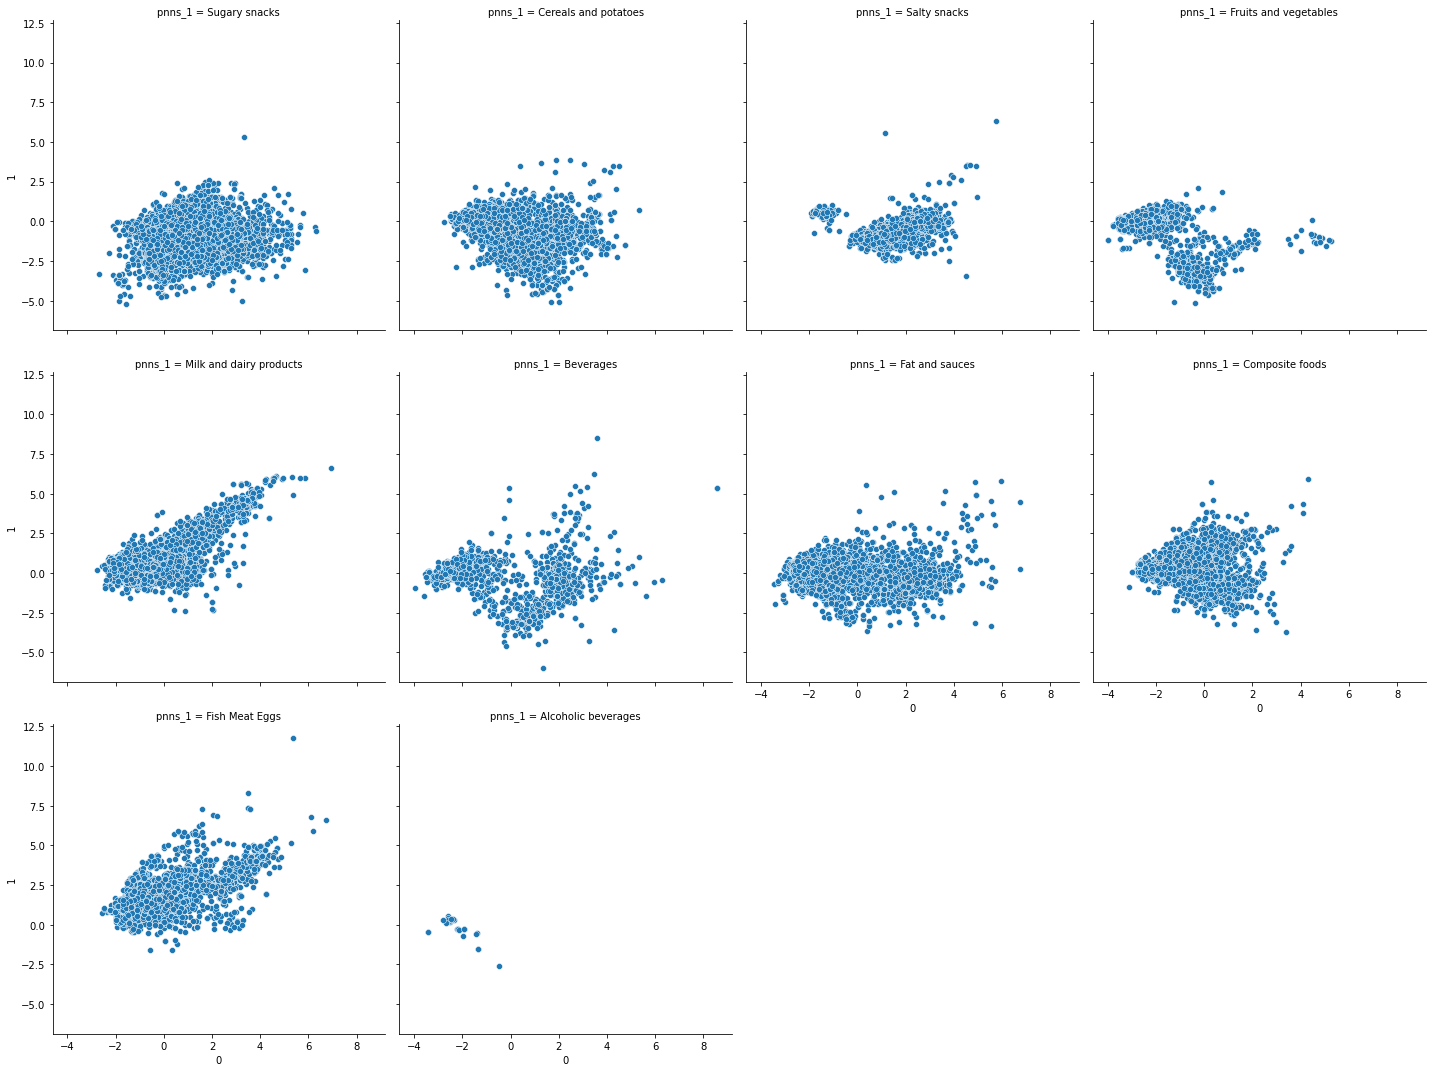

<Figure size 432x288 with 0 Axes>

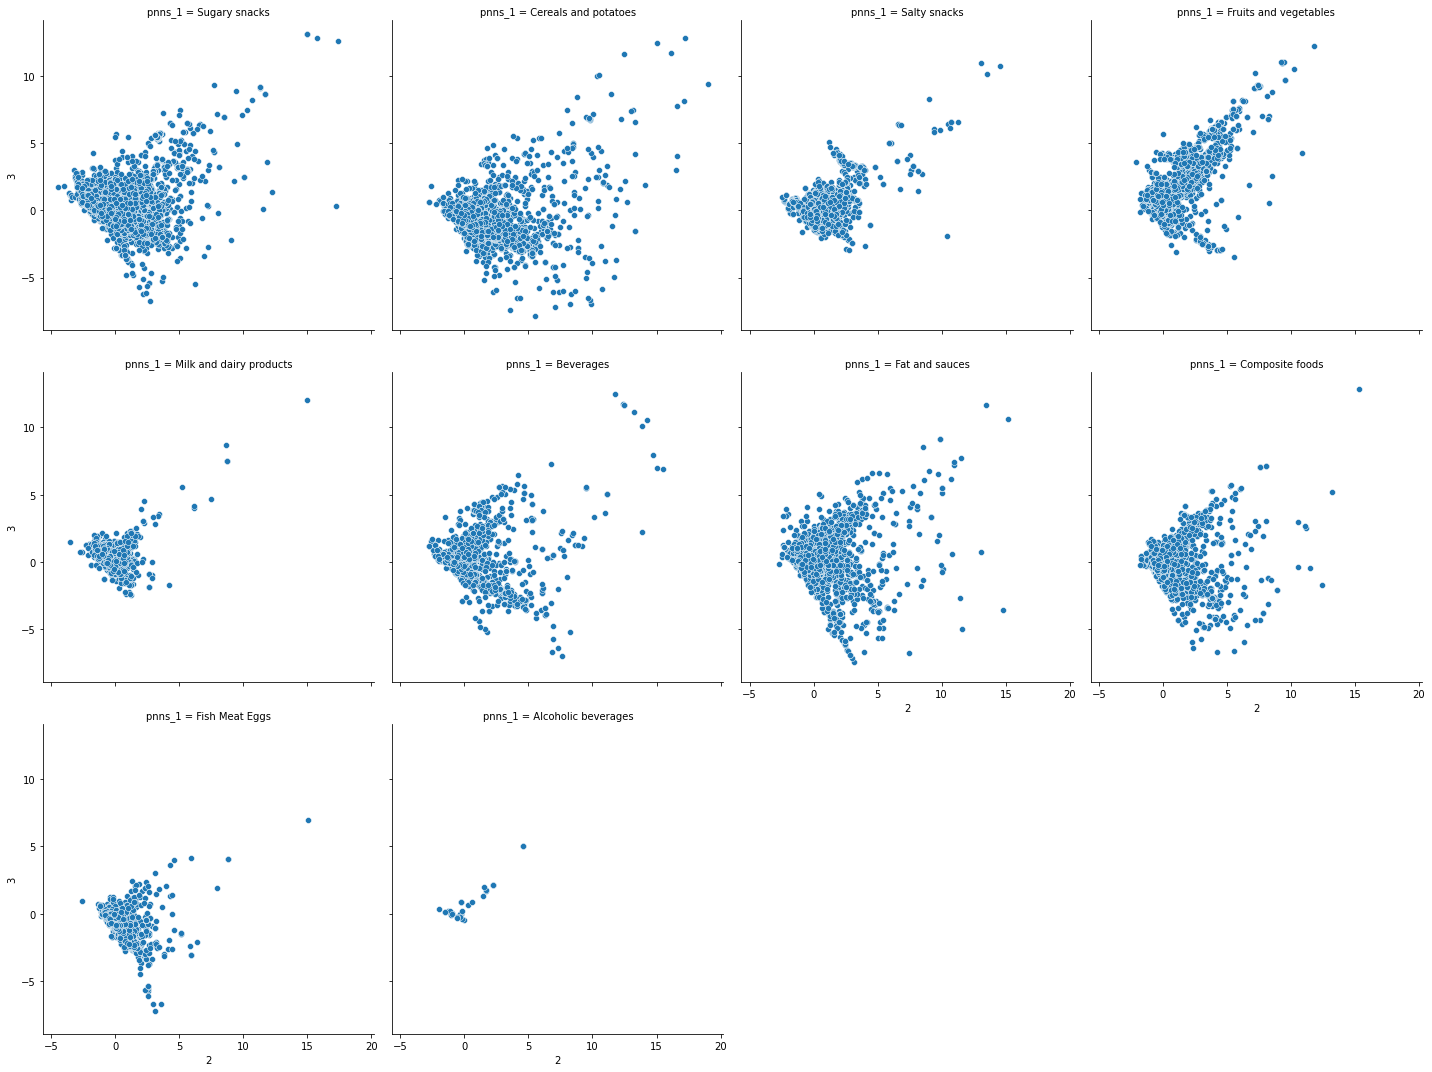

<Figure size 432x288 with 0 Axes>

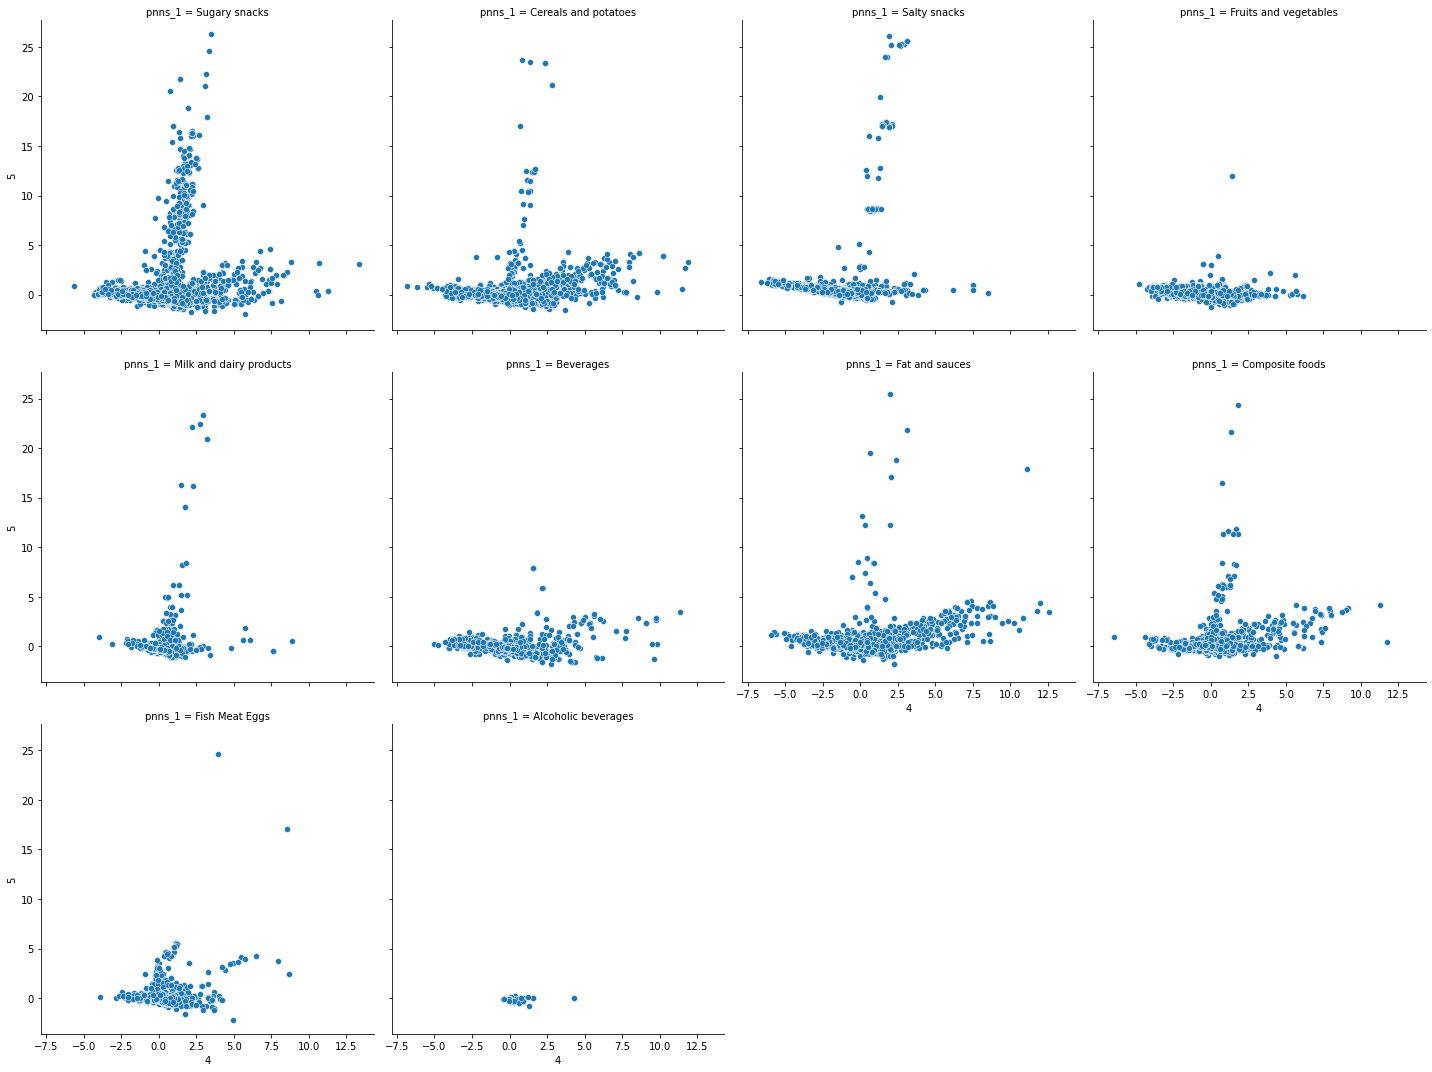

In [54]:
# Construction des graphiques ()
df_pca_pred = pd.DataFrame(Xpca[tab_index], index=keep_ind_pred)
df_pca_pred['pnns_1'] = df_pred.loc[keep_ind_pred]#df_pnns['pnns_groups_1'].loc[keep_ind]#df_pnns.iloc[keep_ind, 'pnns_groups_1']
for i,j in zip(range(0,nb_vecteurs_Kaiser,2), range(1,nb_vecteurs_Kaiser,2)):
    plt.figure(f'Plans factoriels, projection individus separes par pnns1({i},{j})'), plt.clf()
    sns.relplot(data=df_pca_pred, x=i, y=j, col='pnns_1', col_wrap=4)

### On reconnait, particulièrement dans le premier plan factoriel, les formes des distributions spatiales de plusieurs catégories, en particulier :
- Beverages
- Milk and dairy products
- Salty snacks.
### Cela tend à confirme l'efficaicté des prédictions du modèle !